In [137]:
import sys
print(sys.executable)
#We will make a basic CNN model to classify CIFAR-100#
#We will use Keras from Tensorflow to build the model#
import ssl

print(ssl.get_default_verify_paths())



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.metrics import TopKCategoricalAccuracy
import numpy as np
import matplotlib.pyplot as plt
import datetime

#show the tensorflow version
print(tf.__version__)


/usr/local/bin/python3.10
DefaultVerifyPaths(cafile='/Library/Frameworks/Python.framework/Versions/3.10/etc/openssl/cert.pem', capath=None, openssl_cafile_env='SSL_CERT_FILE', openssl_cafile='/Library/Frameworks/Python.framework/Versions/3.10/etc/openssl/cert.pem', openssl_capath_env='SSL_CERT_DIR', openssl_capath='/Library/Frameworks/Python.framework/Versions/3.10/etc/openssl/certs')
2.16.1


In [111]:
#Test if have GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 823911460271639010
xla_global_id: -1
]
[]


In [112]:
#load the CIFAR-100 dataset & split into train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Normalize pixel values from 1-255 to 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0

#show the shape of the dataset
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape) 

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [113]:
#shuffle train & test data

# # Assuming x_train and y_train are your data
# indices = np.arange(x_train.shape[0])
# np.random.shuffle(indices)

# # Let's say we want to select 10000 random samples
# x_train_subset = x_train[indices[:10000]]
# y_train_subset = y_train[indices[:10000]]

In [114]:
import tensorflow as tf

class MaxDropout(tf.keras.layers.Layer):
    def __init__(self, max_rate, **kwargs):
        super(MaxDropout, self).__init__(**kwargs)
        self.max_rate = max_rate  # The maximum possible dropout rate

    def call(self, inputs, training=None):
        if not training:
            return inputs
        
        # Step 3: Dynamically select a dropout rate between 0 and self.max_rate
        rate = tf.random.uniform((), 0, self.max_rate)

        # Step 4: Normalize the tensor using L2 normalization
        norm_tensor = tf.nn.l2_normalize(inputs, axis=None)

        # Step 5: Find the maximum value in the normalized tensor
        max_val = tf.reduce_max(norm_tensor)

        # Step 6: Calculate the threshold to keep
        threshold = (1 - rate) * max_val

        # Step 7: Create a mask for elements greater than the threshold
        kept_idx = tf.cast(norm_tensor < threshold, inputs.dtype)
        # print the number of zeros in kept_idx
        # num_zeros = tf.cast(tf.size(kept_idx), tf.float32) - tf.reduce_sum(kept_idx)
        # tf.print("Number of zeros in the mask:", num_zeros)
        # Step 8: Return the tensor with dropout applied
        return inputs * kept_idx


In [134]:
#Build model
def create_model(dropout_rate, config):

    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if config['first']:
        model.add(MaxDropout(dropout_rate))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if config['second']:
        model.add(MaxDropout(dropout_rate))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if config['third']:
        model.add(MaxDropout(dropout_rate))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if config['fourth']:
        model.add(MaxDropout(dropout_rate))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if config['fifth']:
        model.add(MaxDropout(dropout_rate))

    # Block 4
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))

    # Block 5
    model.add(Dense(10, activation='softmax'))

    # Print the model summary
    model.summary()
    #Compile the model
    model.compile(optimizer='adam',
        # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'])
    return model



In [151]:
#Build model
def create_model_complex(dropout_rates, config):

    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if config['first']:
        model.add(MaxDropout(dropout_rates['first']))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if config['second']:
        model.add(MaxDropout(dropout_rates['second']))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if config['third']:
        model.add(MaxDropout(dropout_rates['third']))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if config['fourth']:
        model.add(MaxDropout(dropout_rates['fourth']))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if config['fifth']:
        model.add(MaxDropout(dropout_rates['fifth']))

    # Block 4
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))

    # Block 5
    model.add(Dense(10, activation='softmax'))

    # Print the model summary
    model.summary()
    #Compile the model
    model.compile(optimizer='adam',
        # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=['accuracy', TopKCategoricalAccuracy(k=3)])
    return model



Training model with MaxDropout rate: {'first': 0.19, 'second': 0.22, 'third': 0.25, 'fourth': 0.28, 'fifth': 0.31} and Config: {'first': True, 'second': True, 'third': True, 'fourth': True, 'fifth': True}


Model: "sequential_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_774 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_775 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_645               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_354 (MaxDropout)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_776 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_646               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_355 (MaxDropout)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_777 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_647               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_356 (MaxDropout)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_778 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_648               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_357 (MaxDropout)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_779 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_649               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_358 (MaxDropout)    │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_129 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_258 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_259 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 29ms/step - accuracy: 0.3226 - loss: 1.7880 - top_k_categorical_accuracy: 0.6489 - val_accuracy: 0.5816 - val_loss: 1.1990 - val_top_k_categorical_accuracy: 0.8596
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.6308 - loss: 1.0398 - top_k_categorical_accuracy: 0.8867 - val_accuracy: 0.6946 - val_loss: 0.8791 - val_top_k_categorical_accuracy: 0.9154
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.7254 - loss: 0.7834 - top_k_categorical_accuracy: 0.9301 - val_accuracy: 0.7349 - val_loss: 0.7807 - val_top_k_categorical_accuracy: 0.9304
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.7753 - loss: 0.6487 - top_k_categorical_accuracy: 0.9495 - val_accuracy: 0.7489 - val_loss: 0.7336 - val_top_k_categorical_accuracy: 0.9377
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.8110 - loss: 0.5520 - top_k_categorical_accuracy: 0.9628 - val_accuracy: 0.7605 - val_loss

<Figure size 1000x1000 with 0 Axes>

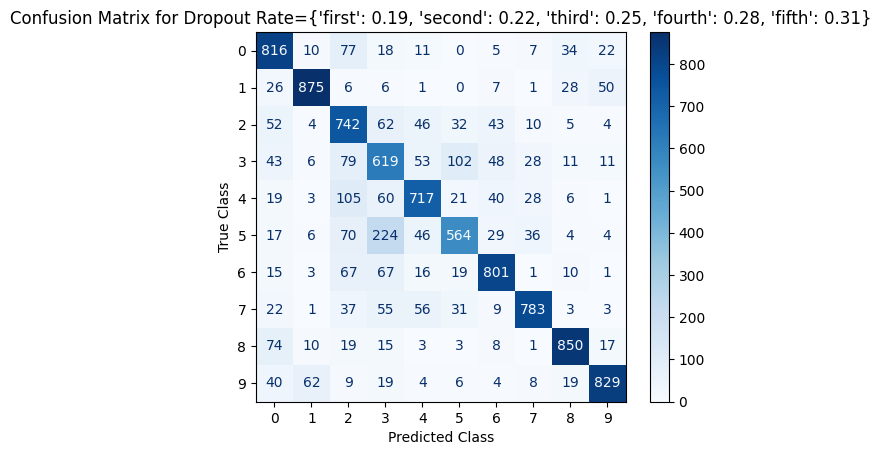

Training model with MaxDropout rate: {'first': 0.25, 'second': 0.25, 'third': 0.25, 'fourth': 0.25, 'fifth': 0.25} and Config: {'first': True, 'second': True, 'third': True, 'fourth': True, 'fifth': True}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_780 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_781 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_650               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_359 (MaxDropout)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_782 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_651               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_360 (MaxDropout)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_783 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_652               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_361 (MaxDropout)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_784 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_653               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_362 (MaxDropout)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_785 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_654               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_363 (MaxDropout)    │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_130 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_260 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_261 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 27ms/step - accuracy: 0.3275 - loss: 1.7781 - top_k_categorical_accuracy: 0.6512 - val_accuracy: 0.5949 - val_loss: 1.1533 - val_top_k_categorical_accuracy: 0.8693
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.6267 - loss: 1.0392 - top_k_categorical_accuracy: 0.8887 - val_accuracy: 0.6492 - val_loss: 0.9837 - val_top_k_categorical_accuracy: 0.9028
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.7176 - loss: 0.8044 - top_k_categorical_accuracy: 0.9271 - val_accuracy: 0.7211 - val_loss: 0.8013 - val_top_k_categorical_accuracy: 0.9327
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.7674 - loss: 0.6673 - top_k_categorical_accuracy: 0.9461 - val_accuracy: 0.7394 - val_loss: 0.7695 - val_top_k_categorical_accuracy: 0.9320
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 48s 31ms/step - accuracy: 0.8044 - loss: 0.5633 - top_k_categorical_accuracy: 0.9606 - val_accuracy: 0.7561 - val_loss

<Figure size 1000x1000 with 0 Axes>

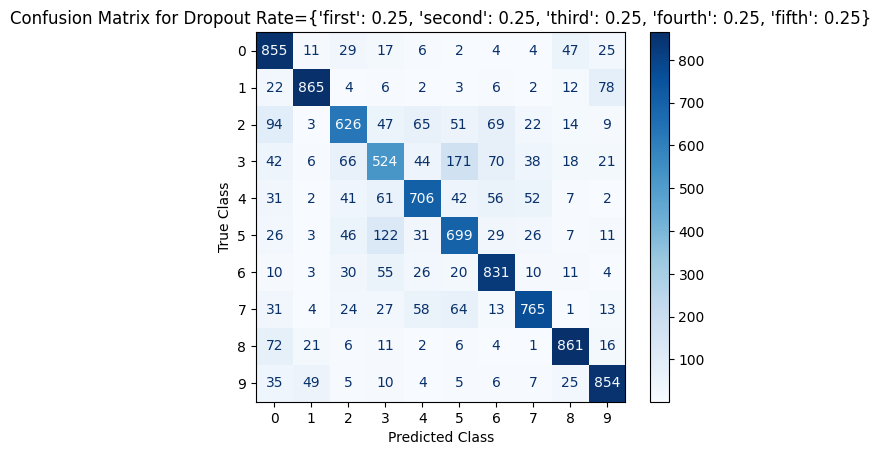

Training model with MaxDropout rate: {'first': 0.31, 'second': 0.28, 'third': 0.25, 'fourth': 0.22, 'fifth': 0.19} and Config: {'first': True, 'second': True, 'third': True, 'fourth': True, 'fifth': True}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_131"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_786 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_787 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_655               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_364 (MaxDropout)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_788 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_656               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_365 (MaxDropout)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_789 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_657               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_366 (MaxDropout)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_790 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_658               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_367 (MaxDropout)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_791 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_659               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_368 (MaxDropout)    │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_131 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_262 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 27ms/step - accuracy: 0.3191 - loss: 1.8004 - top_k_categorical_accuracy: 0.6311 - val_accuracy: 0.6133 - val_loss: 1.0830 - val_top_k_categorical_accuracy: 0.8826
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.6343 - loss: 1.0189 - top_k_categorical_accuracy: 0.8911 - val_accuracy: 0.6415 - val_loss: 1.0104 - val_top_k_categorical_accuracy: 0.8975
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.7286 - loss: 0.7746 - top_k_categorical_accuracy: 0.9329 - val_accuracy: 0.7299 - val_loss: 0.7722 - val_top_k_categorical_accuracy: 0.9306
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.7828 - loss: 0.6256 - top_k_categorical_accuracy: 0.9532 - val_accuracy: 0.7617 - val_loss: 0.7249 - val_top_k_categorical_accuracy: 0.9426
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.8080 - loss: 0.5409 - top_k_categorical_accuracy: 0.9629 - val_accuracy: 0.7540 - val_loss

<Figure size 1000x1000 with 0 Axes>

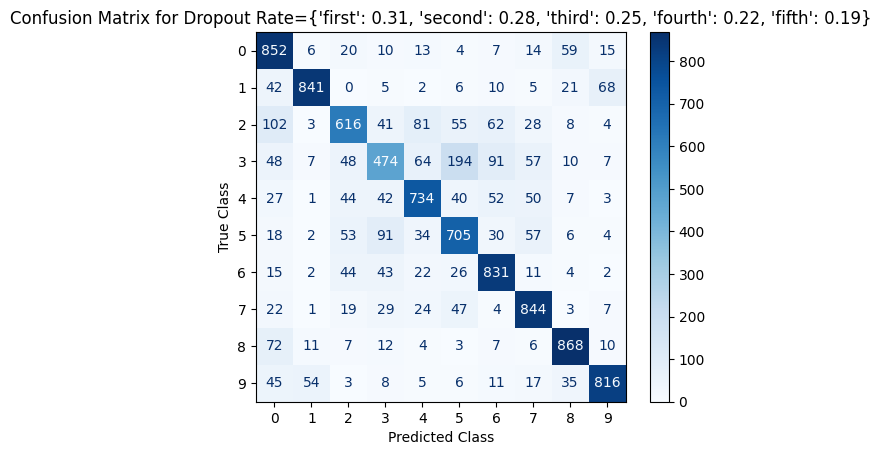

Training model with MaxDropout rate: {'first': 0.3, 'second': 0.2, 'third': 0.15, 'fourth': 0.2, 'fifth': 0.3} and Config: {'first': True, 'second': True, 'third': True, 'fourth': True, 'fifth': True}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_132"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_792 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_793 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_660               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_369 (MaxDropout)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_794 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_661               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_370 (MaxDropout)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_795 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_662               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_371 (MaxDropout)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_796 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_663               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_372 (MaxDropout)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_797 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_664               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_373 (MaxDropout)    │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_132 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_264 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_265 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 29ms/step - accuracy: 0.3023 - loss: 1.8233 - top_k_categorical_accuracy: 0.6248 - val_accuracy: 0.5531 - val_loss: 1.2481 - val_top_k_categorical_accuracy: 0.8384
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.6307 - loss: 1.0348 - top_k_categorical_accuracy: 0.8892 - val_accuracy: 0.6869 - val_loss: 0.8874 - val_top_k_categorical_accuracy: 0.9192
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.7167 - loss: 0.7991 - top_k_categorical_accuracy: 0.9281 - val_accuracy: 0.7235 - val_loss: 0.7878 - val_top_k_categorical_accuracy: 0.9340
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.7676 - loss: 0.6582 - top_k_categorical_accuracy: 0.9470 - val_accuracy: 0.7344 - val_loss: 0.7578 - val_top_k_categorical_accuracy: 0.9340
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.8018 - loss: 0.5698 - top_k_categorical_accuracy: 0.9588 - val_accuracy: 0.7481 - val_loss

<Figure size 1000x1000 with 0 Axes>

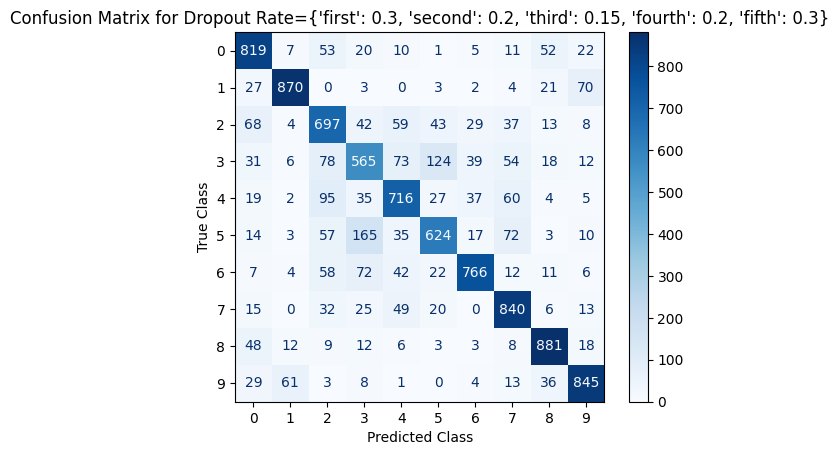

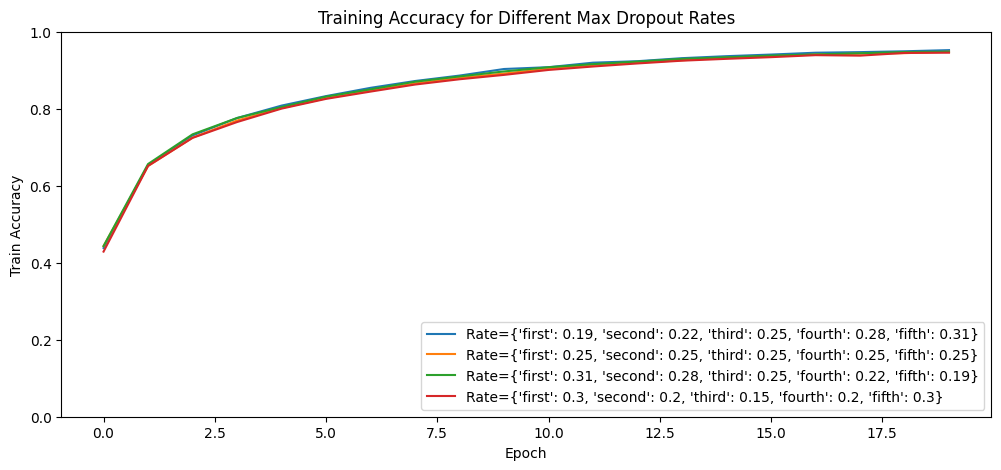

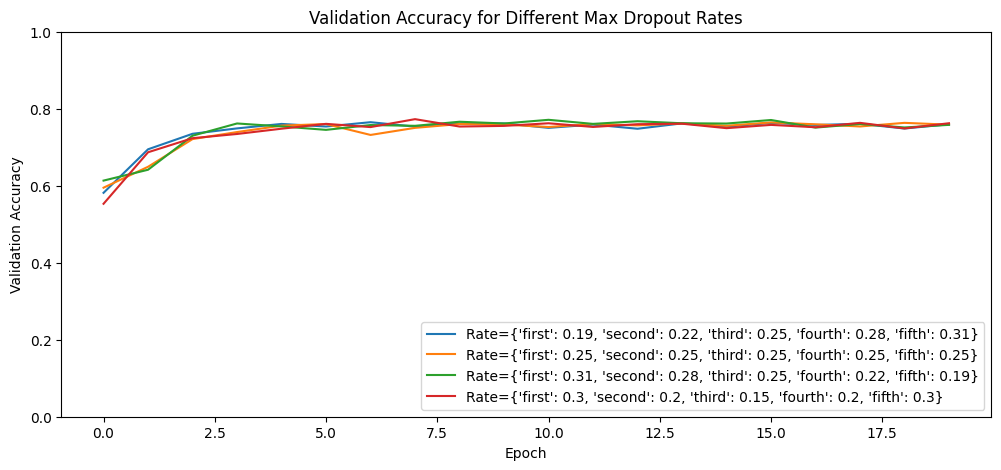

In [161]:
# Code for model with all layers and different dropout rates
y_train_encoded, y_test_encoded = tf.keras.utils.to_categorical(y_train, 10), tf.keras.utils.to_categorical(y_test, 10)

#dropout_rates = [0.04, 0.07, 0.1, 0.15] # r1, r2, r3, r4
dropout_rates = [
    # {'first': .06, 'second': .1, 'third': .2, 'fourth': .35, 'fifth': .5}, # 1
    # {'first': .11, 'second': .18, 'third': .25, 'fourth': .32, 'fifth': .39}, # 2 +- 7
    {'first': .19, 'second': .22, 'third': .25, 'fourth': .28, 'fifth': .31}, # 2 +- 3
    # {'first': .3, 'second': .25, 'third': .2, 'fourth': .25, 'fifth': .4}, # 2 +- 3
    {'first': .25, 'second': .25, 'third': .25, 'fourth': .25, 'fifth': .25}, # 2 +- 0
    {'first': .31, 'second': .28, 'third': .25, 'fourth': .22, 'fifth': .19}, # 2 -+ 7
    {'first': .3, 'second': .2, 'third': .15, 'fourth': .2, 'fifth': .3}, # 2 +- 3

    # {'first': .05, 'second': .05, 'third': .05, 'fourth': .05, 'fifth': .05}, # 2 -+ 7
    # {'first': .4, 'second': .4, 'third': .4, 'fourth': .4, 'fifth': .4} # 2 -+ 7


                 ] 
configurations = [
        #   {'first': True, 'second': True, 'third': False, 'fourth': False, 'fifth': False}, # config 1
        #   {'first': False, 'second': False, 'third': False, 'fourth': True, 'fifth': True}, # config 2
        #   {'first': False, 'second': False, 'third': True, 'fourth': True, 'fifth': False}, # config 3
        #   {'first': False, 'second': False, 'third': True, 'fourth': False, 'fifth': True}, # config 4
        #   {'first': False, 'second': True, 'third': False, 'fourth': True, 'fifth': False}, # config 5
          {'first': True, 'second': True, 'third': True, 'fourth': True, 'fifth': True}, # config 6
          ]
all_histories = []
for config in configurations:
    histories = []
    for rate in dropout_rates:
        print(f"Training model with MaxDropout rate: {rate} and Config: {config}")
        model = create_model_complex(rate, config)

        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

        history = model.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_test, y_test_encoded), callbacks=[tensorboard_callback])
        histories.append(history)

        test_loss, test_acc, test_top_k_acc = model.evaluate(x_test, y_test_encoded, verbose=2)
        print('\nTest accuracy:', test_acc)
        print('Test top-3 categorical accuracy:', test_top_k_acc)

        print('\nTest accuracy for rate {}: {}'.format(rate, test_acc))
        # Prediction
        y_pred = model.predict(x_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test_encoded, axis=1)

        # Compute the confusion matrix
        cm = confusion_matrix(y_true_classes, y_pred_classes)

        # Display the confusion matrix
        plt.figure(figsize=(10, 10))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for Dropout Rate={rate}')
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.show()
        


    #Plot the accuracies
    plt.figure(figsize=(12, 5))
    for i, history in enumerate(histories):
        plt.plot(history.history['accuracy'], label=f'Rate={dropout_rates[i]}')

    plt.title('Training Accuracy for Different Max Dropout Rates')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

    plt.figure(figsize=(12, 5))
    for i, history in enumerate(histories):
        plt.plot(history.history['val_accuracy'], label=f'Rate={dropout_rates[i]}')

    plt.title('Validation Accuracy for Different Max Dropout Rates')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

    all_histories.append(histories)
    

dict_keys(['accuracy', 'loss', 'top_k_categorical_accuracy', 'val_accuracy', 'val_loss', 'val_top_k_categorical_accuracy'])
Max validation accuracy for rate {'first': 0.19, 'second': 0.22, 'third': 0.25, 'fourth': 0.28, 'fifth': 0.31}: 0.7649999856948853
Max validation top k accuracy for rate {'first': 0.19, 'second': 0.22, 'third': 0.25, 'fourth': 0.28, 'fifth': 0.31}: 0.9441999793052673
Max validation accuracy for rate {'first': 0.25, 'second': 0.25, 'third': 0.25, 'fourth': 0.25, 'fifth': 0.25}: 0.7644000053405762
Max validation top k accuracy for rate {'first': 0.25, 'second': 0.25, 'third': 0.25, 'fourth': 0.25, 'fifth': 0.25}: 0.9398999810218811
Max validation accuracy for rate {'first': 0.31, 'second': 0.28, 'third': 0.25, 'fourth': 0.22, 'fifth': 0.19}: 0.7712000012397766
Max validation top k accuracy for rate {'first': 0.31, 'second': 0.28, 'third': 0.25, 'fourth': 0.22, 'fifth': 0.19}: 0.9433000087738037
Max validation accuracy for rate {'first': 0.3, 'second': 0.2, 'third': 

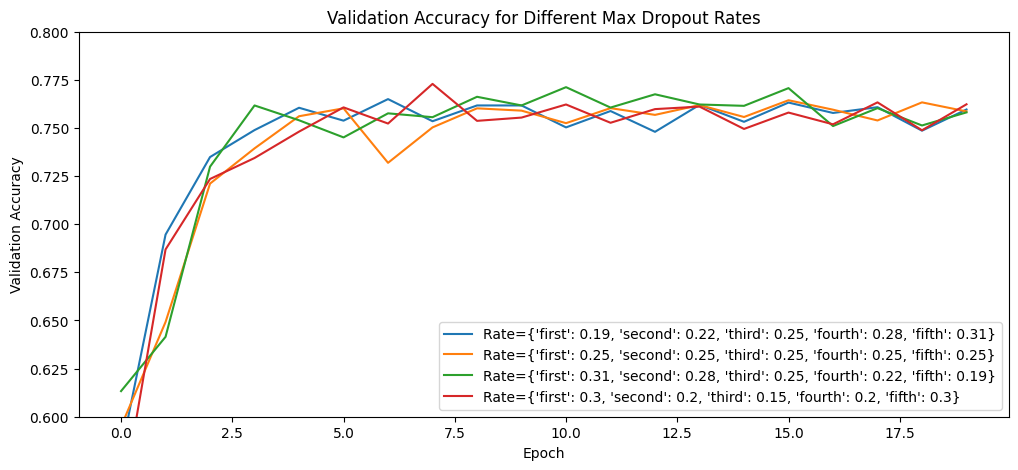

Min validation loss for rate {'first': 0.19, 'second': 0.22, 'third': 0.25, 'fourth': 0.28, 'fifth': 0.31}: 0.7336074709892273
Min validation loss for rate {'first': 0.25, 'second': 0.25, 'third': 0.25, 'fourth': 0.25, 'fifth': 0.25}: 0.7324327230453491
Min validation loss for rate {'first': 0.31, 'second': 0.28, 'third': 0.25, 'fourth': 0.22, 'fifth': 0.19}: 0.7248815894126892
Min validation loss for rate {'first': 0.3, 'second': 0.2, 'third': 0.15, 'fourth': 0.2, 'fifth': 0.3}: 0.7279987335205078


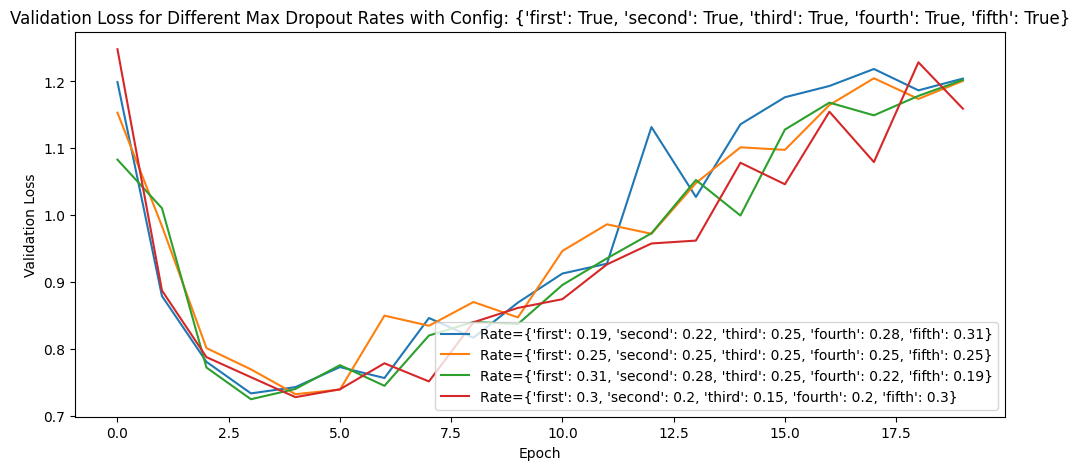

In [162]:
print(history.history.keys())

for config in configurations:
    histories = all_histories[configurations.index(config)]
    plt.figure(figsize=(12, 5))
    for i, history in enumerate(histories):
        plt.plot(history.history['val_accuracy'], label=f'Rate={dropout_rates[i]}')
        # find max validation accuracy and print
        max_val_acc = max(history.history['val_accuracy'])
        print(f'Max validation accuracy for rate {dropout_rates[i]}: {max_val_acc}')
        max_val_top_k = max(history.history['val_top_k_categorical_accuracy'])
        print(f'Max validation top k accuracy for rate {dropout_rates[i]}: {max_val_top_k}')
        
        # find generalization gap of the model at the point of max validation accuracy
        # max_val_acc_idx = history.history['val_accuracy'].index(max_val_acc)
        # generalization_gap = max_val_acc - history.history['accuracy'][max_val_acc_idx]
        # print(f'Generalization gap for rate {dropout_rates[i]}: {generalization_gap}')

    plt.title('Validation Accuracy for Different Max Dropout Rates')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.ylim([.6, .8])
    plt.legend(loc='lower right')
    plt.show()    

    plt.figure(figsize=(12, 5))
    for i, history in enumerate(histories):
        plt.plot(history.history['val_loss'], label=f'Rate={dropout_rates[i]}')
        min_val_loss = min(history.history['val_loss'])
        print(f'Min validation loss for rate {dropout_rates[i]}: {min_val_loss}')

    plt.title('Validation Loss for Different Max Dropout Rates with Config: {}'.format(config))
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    # plt.ylim([.6, .8])
    plt.legend(loc='lower right')
    plt.show()    





Training model with MaxDropout rate: 0.04 and Config: {'first': True, 'second': True, 'third': False, 'fourth': False, 'fifth': False}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_594 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_595 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_495               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_264 (MaxDropout)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_596 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_496               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_265 (MaxDropout)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_597 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_497               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_598 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_498               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_599 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_499               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_99 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 30ms/step - accuracy: 0.3298 - loss: 1.7722 - val_accuracy: 0.5974 - val_loss: 1.1277
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.6311 - loss: 1.0435 - val_accuracy: 0.6418 - val_loss: 1.0287
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.7142 - loss: 0.8131 - val_accuracy: 0.7107 - val_loss: 0.8253
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.7695 - loss: 0.6622 - val_accuracy: 0.7164 - val_loss: 0.8166
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.7996 - loss: 0.5721 - val_accuracy: 0.7387 - val_loss: 0.7694
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.8286 - loss: 0.4895 - val_accuracy: 0.7530 - val_loss: 0.7672
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.8548 - loss: 0.4132 - val_accuracy: 0.7551 - val_loss: 0.7793
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8769 -

<Figure size 1000x1000 with 0 Axes>

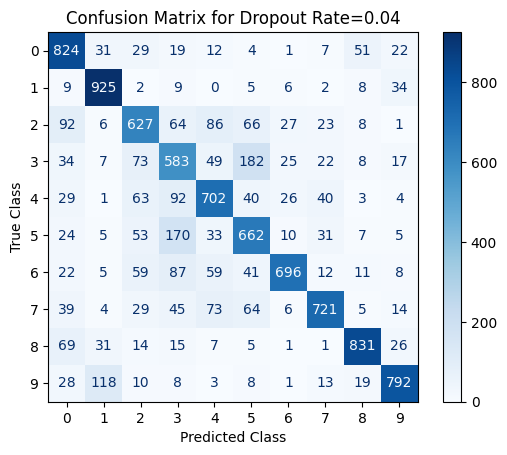

Training model with MaxDropout rate: 0.1 and Config: {'first': True, 'second': True, 'third': False, 'fourth': False, 'fifth': False}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_600 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_601 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_500               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_266 (MaxDropout)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_602 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_501               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_267 (MaxDropout)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_603 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_502               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_604 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_503               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_605 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_504               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_100 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - accuracy: 0.3265 - loss: 1.7723 - val_accuracy: 0.5580 - val_loss: 1.2272
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.5953 - loss: 1.1185 - val_accuracy: 0.6579 - val_loss: 0.9771
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.7094 - loss: 0.8176 - val_accuracy: 0.7077 - val_loss: 0.8373
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.7685 - loss: 0.6640 - val_accuracy: 0.7459 - val_loss: 0.7592
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8077 - loss: 0.5529 - val_accuracy: 0.7336 - val_loss: 0.7935
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8362 - loss: 0.4644 - val_accuracy: 0.7454 - val_loss: 0.7947
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.8607 - loss: 0.3997 - val_accuracy: 0.7567 - val_loss: 0.7846
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.8805 -

<Figure size 1000x1000 with 0 Axes>

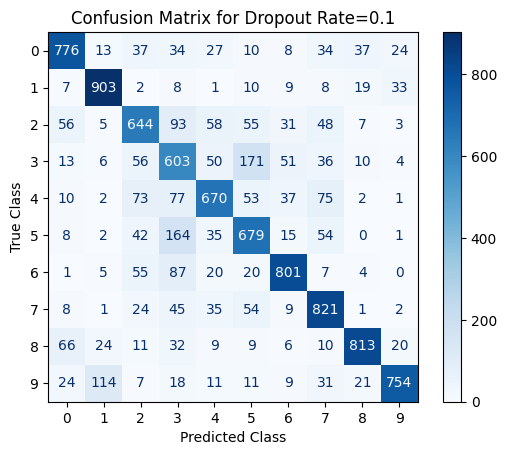

Training model with MaxDropout rate: 0.25 and Config: {'first': True, 'second': True, 'third': False, 'fourth': False, 'fifth': False}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_606 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_607 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_505               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_268 (MaxDropout)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_608 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_506               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_269 (MaxDropout)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_609 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_507               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_610 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_508               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_611 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_509               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_101 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 29ms/step - accuracy: 0.2819 - loss: 1.8733 - val_accuracy: 0.5749 - val_loss: 1.1779
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.6020 - loss: 1.1068 - val_accuracy: 0.6702 - val_loss: 0.9348
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.6887 - loss: 0.8790 - val_accuracy: 0.6895 - val_loss: 0.8791
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.7429 - loss: 0.7346 - val_accuracy: 0.7161 - val_loss: 0.8170
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.7746 - loss: 0.6439 - val_accuracy: 0.7254 - val_loss: 0.8031
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.7993 - loss: 0.5732 - val_accuracy: 0.7307 - val_loss: 0.7870
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8262 - loss: 0.4962 - val_accuracy: 0.7471 - val_loss: 0.7623
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8380 -

<Figure size 1000x1000 with 0 Axes>

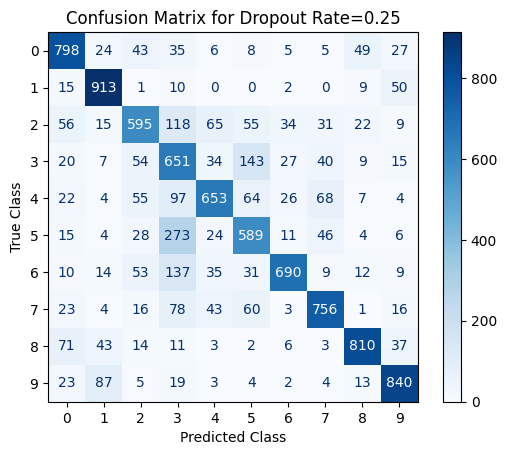

Training model with MaxDropout rate: 0.4 and Config: {'first': True, 'second': True, 'third': False, 'fourth': False, 'fifth': False}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_612 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_613 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_510               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_270 (MaxDropout)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_614 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_511               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_271 (MaxDropout)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_615 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_512               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_616 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_513               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_617 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_514               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_102 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 410s 261ms/step - accuracy: 0.3103 - loss: 1.7958 - val_accuracy: 0.5795 - val_loss: 1.1511
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 103s 66ms/step - accuracy: 0.6182 - loss: 1.0544 - val_accuracy: 0.6987 - val_loss: 0.8684
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 48s 30ms/step - accuracy: 0.7127 - loss: 0.8149 - val_accuracy: 0.7111 - val_loss: 0.8353
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.7616 - loss: 0.6754 - val_accuracy: 0.7337 - val_loss: 0.7606
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.7964 - loss: 0.5775 - val_accuracy: 0.7489 - val_loss: 0.7524
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8204 - loss: 0.5096 - val_accuracy: 0.7520 - val_loss: 0.7544
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8452 - loss: 0.4321 - val_accuracy: 0.7340 - val_loss: 0.8266
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.866

<Figure size 1000x1000 with 0 Axes>

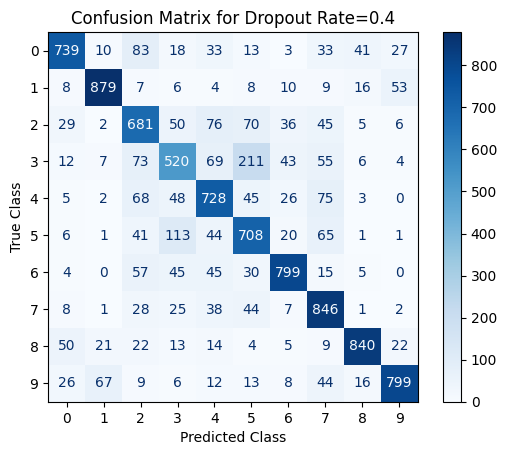

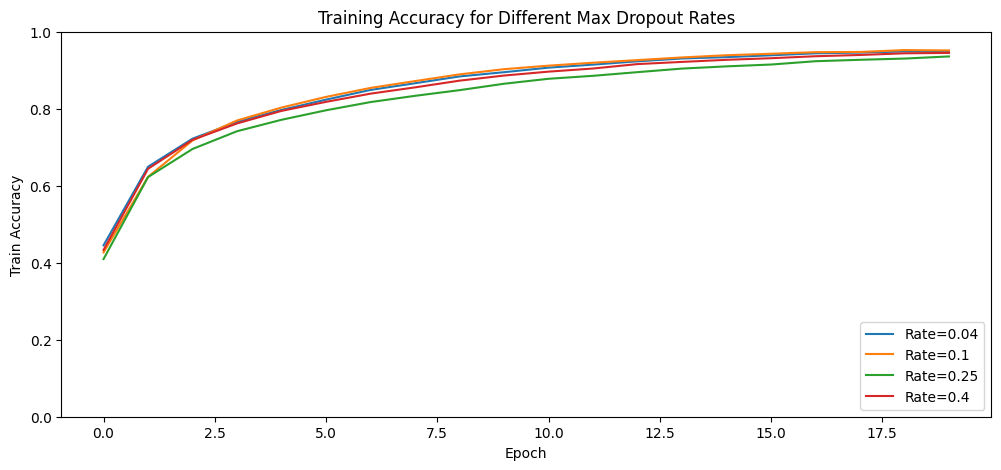

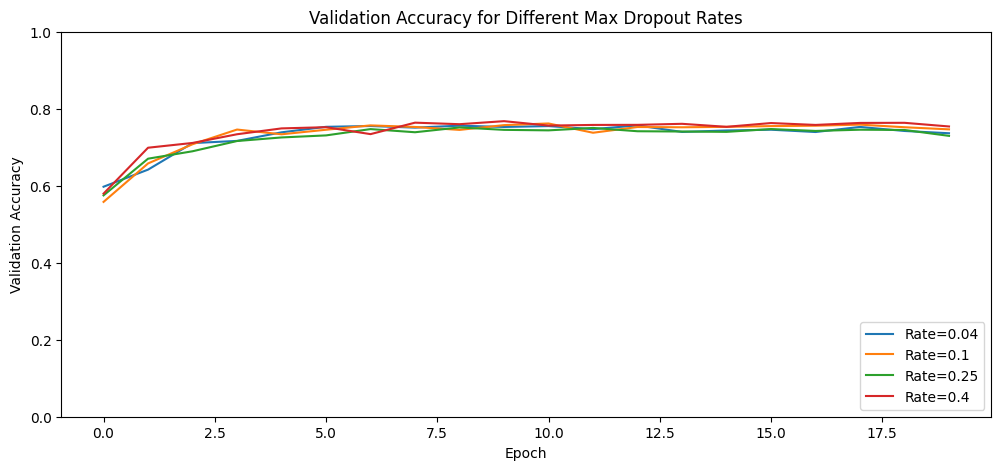

Training model with MaxDropout rate: 0.04 and Config: {'first': False, 'second': False, 'third': False, 'fourth': True, 'fifth': True}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_618 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_619 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_515               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_620 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_516               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_621 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_517               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_622 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_518               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_272 (MaxDropout)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_623 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_519               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_273 (MaxDropout)    │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_103 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - accuracy: 0.3079 - loss: 1.8201 - val_accuracy: 0.5434 - val_loss: 1.2384
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.6042 - loss: 1.0937 - val_accuracy: 0.6861 - val_loss: 0.8888
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.7094 - loss: 0.8298 - val_accuracy: 0.7168 - val_loss: 0.8052
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.7641 - loss: 0.6748 - val_accuracy: 0.7264 - val_loss: 0.8074
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.8025 - loss: 0.5658 - val_accuracy: 0.7524 - val_loss: 0.7424
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8312 - loss: 0.4877 - val_accuracy: 0.7500 - val_loss: 0.8002
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8536 - loss: 0.4202 - val_accuracy: 0.7607 - val_loss: 0.7599
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8710 -

<Figure size 1000x1000 with 0 Axes>

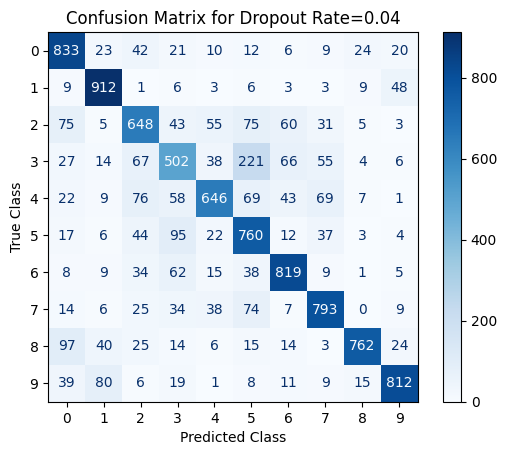

Training model with MaxDropout rate: 0.1 and Config: {'first': False, 'second': False, 'third': False, 'fourth': True, 'fifth': True}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_624 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_625 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_520               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_626 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_521               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_627 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_522               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_628 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_523               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_274 (MaxDropout)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_629 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_524               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_275 (MaxDropout)    │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_104 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 54s 27ms/step - accuracy: 0.3047 - loss: 1.8356 - val_accuracy: 0.5674 - val_loss: 1.2039
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.6191 - loss: 1.0577 - val_accuracy: 0.6849 - val_loss: 0.8990
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.7097 - loss: 0.8204 - val_accuracy: 0.6952 - val_loss: 0.8638
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.7595 - loss: 0.6791 - val_accuracy: 0.7331 - val_loss: 0.7736
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8028 - loss: 0.5625 - val_accuracy: 0.7494 - val_loss: 0.7562
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.8289 - loss: 0.4866 - val_accuracy: 0.7520 - val_loss: 0.7402
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.8467 - loss: 0.4378 - val_accuracy: 0.7501 - val_loss: 0.7748
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8650 -

<Figure size 1000x1000 with 0 Axes>

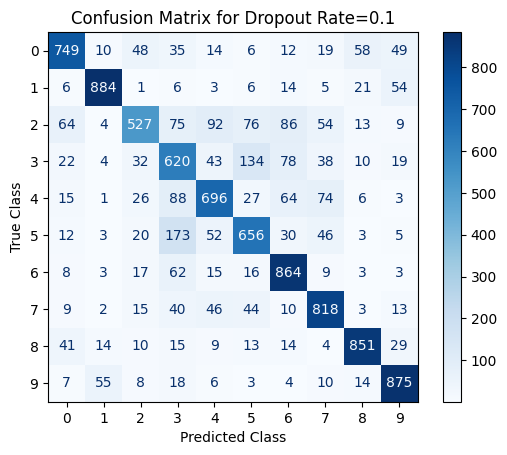

Training model with MaxDropout rate: 0.25 and Config: {'first': False, 'second': False, 'third': False, 'fourth': True, 'fifth': True}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_630 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_631 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_525               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_632 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_526               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_633 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_527               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_634 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_528               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_276 (MaxDropout)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_635 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_529               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_277 (MaxDropout)    │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_105 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_210 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 31ms/step - accuracy: 0.2833 - loss: 1.8833 - val_accuracy: 0.5875 - val_loss: 1.1526
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.6075 - loss: 1.0851 - val_accuracy: 0.6499 - val_loss: 1.0070
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.7003 - loss: 0.8472 - val_accuracy: 0.7204 - val_loss: 0.8021
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.7546 - loss: 0.6980 - val_accuracy: 0.7261 - val_loss: 0.7881
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.7971 - loss: 0.5842 - val_accuracy: 0.7199 - val_loss: 0.8409
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.8234 - loss: 0.5008 - val_accuracy: 0.7508 - val_loss: 0.7497
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 32ms/step - accuracy: 0.8473 - loss: 0.4360 - val_accuracy: 0.7486 - val_loss: 0.8090
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 91ms/step - accuracy: 0.8712 

<Figure size 1000x1000 with 0 Axes>

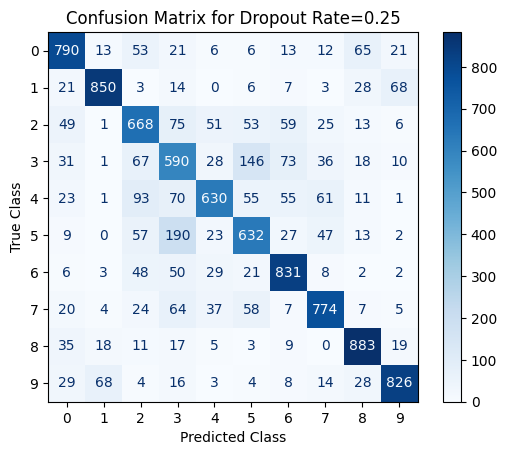

Training model with MaxDropout rate: 0.4 and Config: {'first': False, 'second': False, 'third': False, 'fourth': True, 'fifth': True}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_636 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_637 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_530               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_638 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_531               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_639 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_532               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_640 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_533               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_278 (MaxDropout)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_641 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_534               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_279 (MaxDropout)    │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_106 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 444s 282ms/step - accuracy: 0.3241 - loss: 1.7962 - val_accuracy: 0.5865 - val_loss: 1.1687
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 443s 284ms/step - accuracy: 0.6358 - loss: 1.0182 - val_accuracy: 0.6733 - val_loss: 0.9389
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 347s 222ms/step - accuracy: 0.7238 - loss: 0.7877 - val_accuracy: 0.7386 - val_loss: 0.7676
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.7732 - loss: 0.6539 - val_accuracy: 0.7450 - val_loss: 0.7527
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1507s 965ms/step - accuracy: 0.8068 - loss: 0.5555 - val_accuracy: 0.7486 - val_loss: 0.7617
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 309s 198ms/step - accuracy: 0.8372 - loss: 0.4676 - val_accuracy: 0.7682 - val_loss: 0.7353
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 917s 587ms/step - accuracy: 0.8609 - loss: 0.3986 - val_accuracy: 0.7513 - val_loss: 0.8157
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 179s 115ms/step - acc

<Figure size 1000x1000 with 0 Axes>

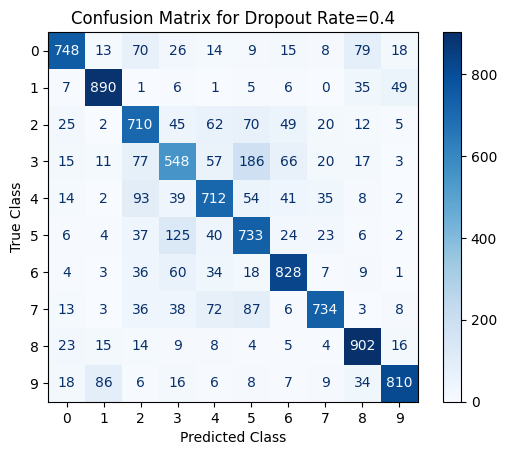

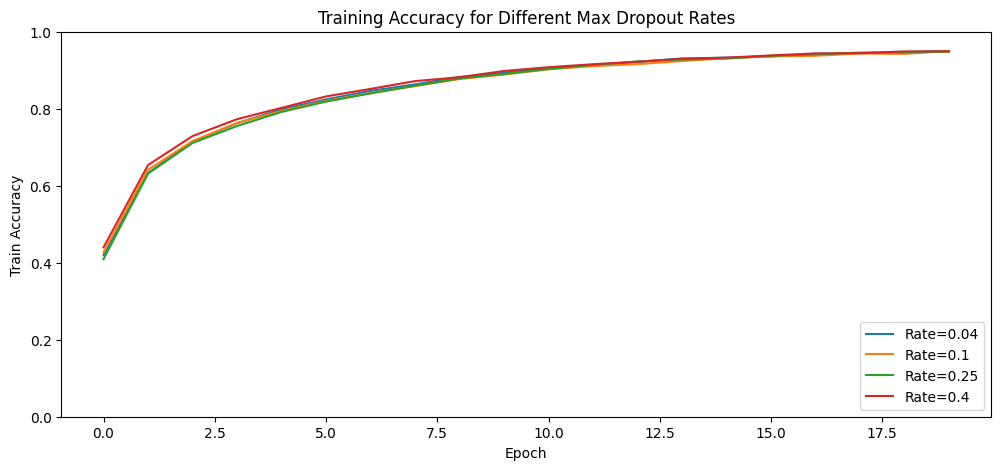

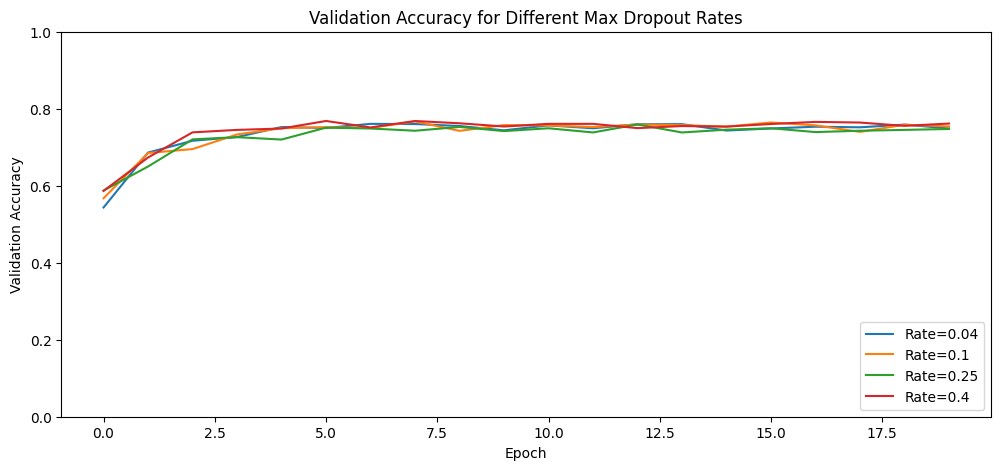

Training model with MaxDropout rate: 0.04 and Config: {'first': False, 'second': False, 'third': True, 'fourth': True, 'fifth': False}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_642 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_643 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_535               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_644 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_536               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_645 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_537               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_280 (MaxDropout)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_646 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_538               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_281 (MaxDropout)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_647 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_539               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_107 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 53s 32ms/step - accuracy: 0.3283 - loss: 1.7774 - val_accuracy: 0.5884 - val_loss: 1.1377
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.6282 - loss: 1.0425 - val_accuracy: 0.6542 - val_loss: 0.9808
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.7166 - loss: 0.8093 - val_accuracy: 0.7295 - val_loss: 0.7822
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 48s 30ms/step - accuracy: 0.7638 - loss: 0.6685 - val_accuracy: 0.7371 - val_loss: 0.7587
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.7985 - loss: 0.5741 - val_accuracy: 0.7510 - val_loss: 0.7546
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.8265 - loss: 0.4925 - val_accuracy: 0.7467 - val_loss: 0.7343
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.8496 - loss: 0.4342 - val_accuracy: 0.7582 - val_loss: 0.7693
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.8683 -

<Figure size 1000x1000 with 0 Axes>

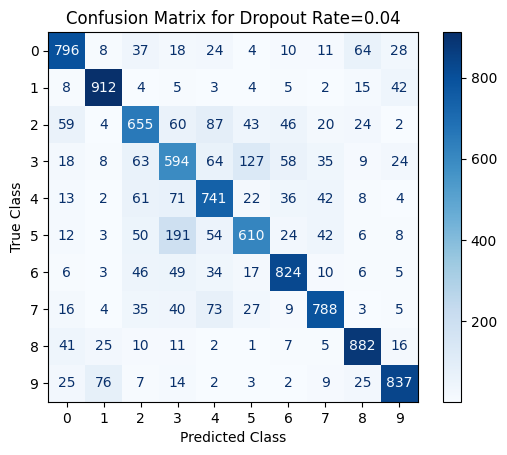

Training model with MaxDropout rate: 0.1 and Config: {'first': False, 'second': False, 'third': True, 'fourth': True, 'fifth': False}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_108"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_648 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_649 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_540               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_650 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_541               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_651 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_542               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_282 (MaxDropout)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_652 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_543               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_283 (MaxDropout)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_653 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_544               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_108 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_217 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - accuracy: 0.3334 - loss: 1.7637 - val_accuracy: 0.5952 - val_loss: 1.1048
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.6408 - loss: 1.0013 - val_accuracy: 0.6949 - val_loss: 0.8809
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.7290 - loss: 0.7733 - val_accuracy: 0.7358 - val_loss: 0.7652
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.7715 - loss: 0.6463 - val_accuracy: 0.7328 - val_loss: 0.7881
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8112 - loss: 0.5409 - val_accuracy: 0.7585 - val_loss: 0.7442
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.8361 - loss: 0.4692 - val_accuracy: 0.7544 - val_loss: 0.7993
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.8629 - loss: 0.3914 - val_accuracy: 0.7641 - val_loss: 0.7579
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8819 -

<Figure size 1000x1000 with 0 Axes>

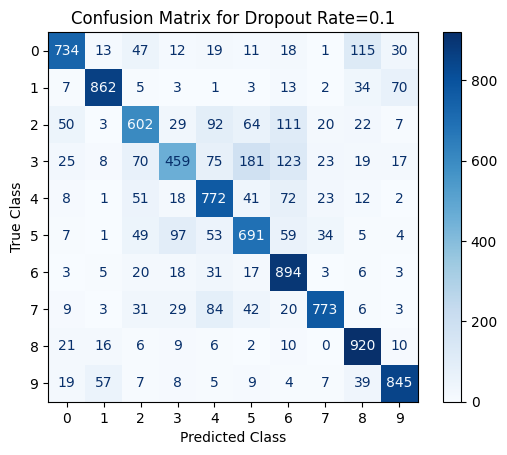

Training model with MaxDropout rate: 0.25 and Config: {'first': False, 'second': False, 'third': True, 'fourth': True, 'fifth': False}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_654 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_655 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_545               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_656 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_546               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_657 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_547               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_284 (MaxDropout)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_658 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_548               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_285 (MaxDropout)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_659 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_549               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_109 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 27ms/step - accuracy: 0.3280 - loss: 1.7709 - val_accuracy: 0.5957 - val_loss: 1.1389
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.6184 - loss: 1.0519 - val_accuracy: 0.6852 - val_loss: 0.8941
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.7187 - loss: 0.7924 - val_accuracy: 0.7212 - val_loss: 0.8109
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.7726 - loss: 0.6550 - val_accuracy: 0.7425 - val_loss: 0.7637
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.8048 - loss: 0.5592 - val_accuracy: 0.7461 - val_loss: 0.7771
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 48s 31ms/step - accuracy: 0.8361 - loss: 0.4641 - val_accuracy: 0.7383 - val_loss: 0.7829
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8583 - loss: 0.4069 - val_accuracy: 0.7600 - val_loss: 0.7587
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.8782 -

<Figure size 1000x1000 with 0 Axes>

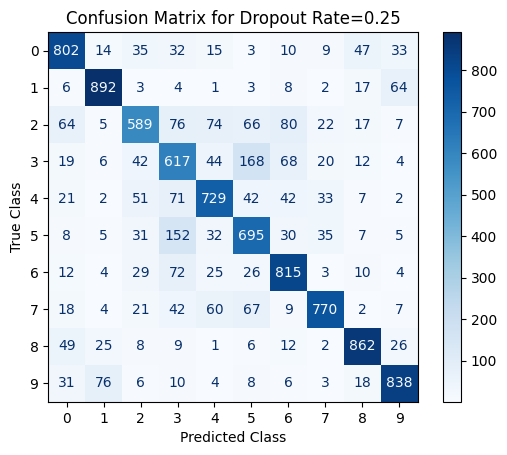

Training model with MaxDropout rate: 0.4 and Config: {'first': False, 'second': False, 'third': True, 'fourth': True, 'fifth': False}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_660 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_661 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_550               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_662 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_551               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_663 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_552               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_286 (MaxDropout)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_664 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_553               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_287 (MaxDropout)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_665 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_554               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_110 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 27ms/step - accuracy: 0.3236 - loss: 1.7939 - val_accuracy: 0.5739 - val_loss: 1.2047
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.6289 - loss: 1.0447 - val_accuracy: 0.6715 - val_loss: 0.9428
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.7132 - loss: 0.8128 - val_accuracy: 0.7187 - val_loss: 0.8418
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.7651 - loss: 0.6710 - val_accuracy: 0.7377 - val_loss: 0.7610
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.7993 - loss: 0.5716 - val_accuracy: 0.7482 - val_loss: 0.7570
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8300 - loss: 0.4834 - val_accuracy: 0.7492 - val_loss: 0.7700
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8502 - loss: 0.4248 - val_accuracy: 0.7603 - val_loss: 0.7541
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8685 -

<Figure size 1000x1000 with 0 Axes>

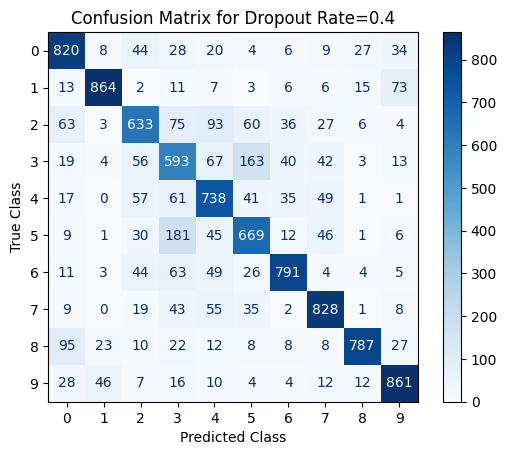

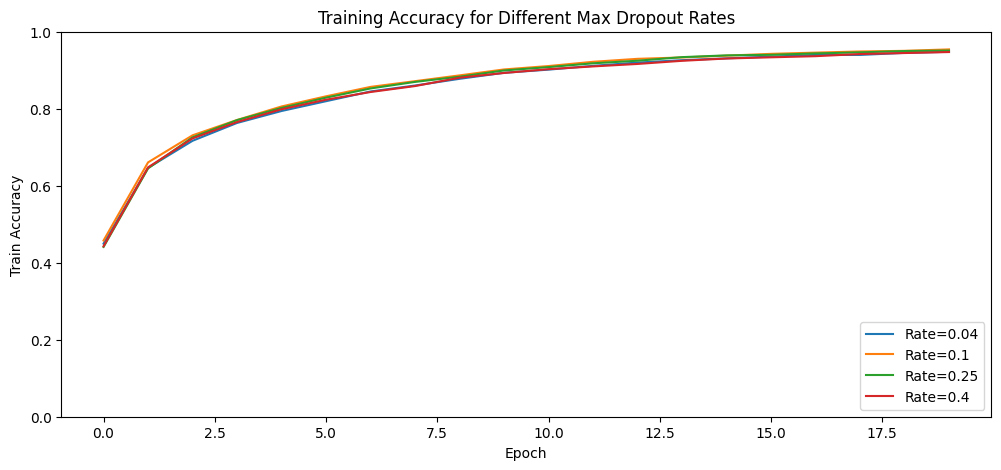

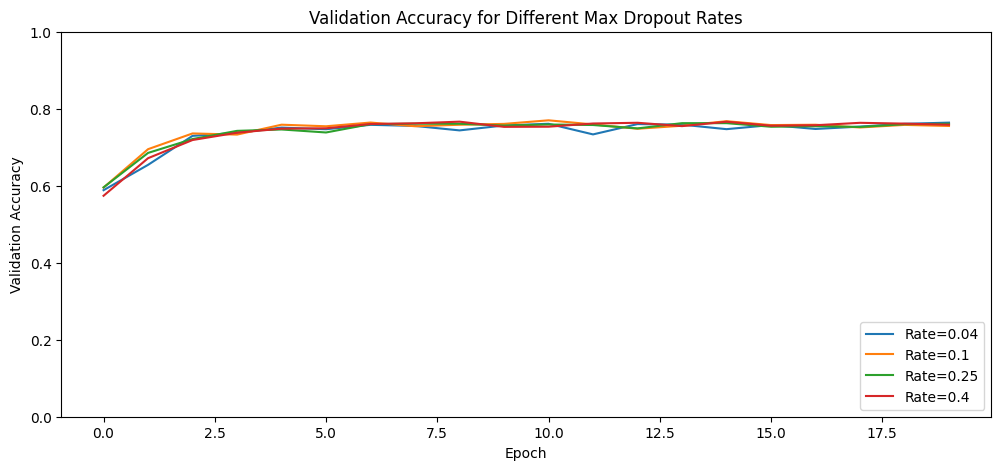

Training model with MaxDropout rate: 0.04 and Config: {'first': False, 'second': False, 'third': True, 'fourth': False, 'fifth': True}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_666 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_667 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_555               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_668 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_556               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_669 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_557               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_288 (MaxDropout)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_670 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_558               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_671 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_559               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_289 (MaxDropout)    │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_111 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - accuracy: 0.3340 - loss: 1.7711 - val_accuracy: 0.5817 - val_loss: 1.1597
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.6292 - loss: 1.0358 - val_accuracy: 0.6972 - val_loss: 0.8619
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.7265 - loss: 0.7833 - val_accuracy: 0.7193 - val_loss: 0.8129
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.7736 - loss: 0.6504 - val_accuracy: 0.7378 - val_loss: 0.7747
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8061 - loss: 0.5526 - val_accuracy: 0.7503 - val_loss: 0.7484
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.8336 - loss: 0.4795 - val_accuracy: 0.7584 - val_loss: 0.7620
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.8540 - loss: 0.4118 - val_accuracy: 0.7554 - val_loss: 0.7847
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.8774 -

<Figure size 1000x1000 with 0 Axes>

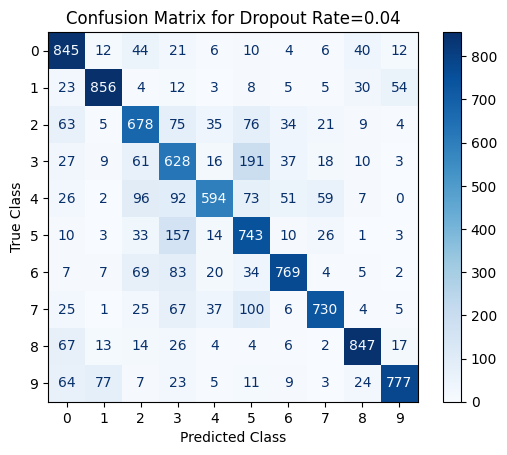

Training model with MaxDropout rate: 0.1 and Config: {'first': False, 'second': False, 'third': True, 'fourth': False, 'fifth': True}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_672 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_673 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_560               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_674 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_561               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_675 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_562               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_290 (MaxDropout)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_676 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_563               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_677 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_564               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_291 (MaxDropout)    │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_112 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_224 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - accuracy: 0.2647 - loss: 1.9460 - val_accuracy: 0.5641 - val_loss: 1.2029
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.5827 - loss: 1.1461 - val_accuracy: 0.6468 - val_loss: 0.9906
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.6784 - loss: 0.9065 - val_accuracy: 0.6936 - val_loss: 0.8676
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.7332 - loss: 0.7582 - val_accuracy: 0.7104 - val_loss: 0.8436
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.7724 - loss: 0.6495 - val_accuracy: 0.7426 - val_loss: 0.7561
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.7982 - loss: 0.5776 - val_accuracy: 0.7354 - val_loss: 0.8123
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 39ms/step - accuracy: 0.8239 - loss: 0.5007 - val_accuracy: 0.7504 - val_loss: 0.7670
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.8418 -

<Figure size 1000x1000 with 0 Axes>

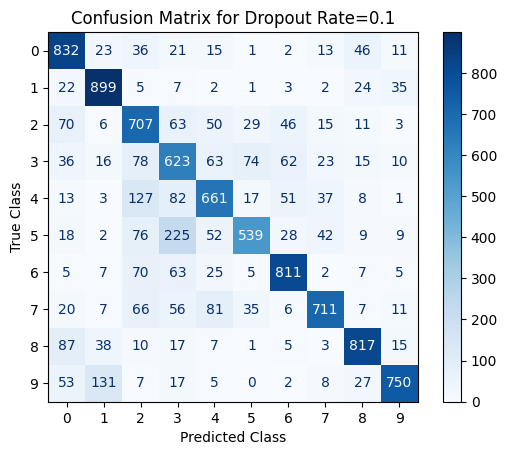

Training model with MaxDropout rate: 0.25 and Config: {'first': False, 'second': False, 'third': True, 'fourth': False, 'fifth': True}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_678 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_679 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_565               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_680 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_566               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_681 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_567               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_292 (MaxDropout)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_682 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_568               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_683 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_569               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_293 (MaxDropout)    │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_113 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 31ms/step - accuracy: 0.3202 - loss: 1.7895 - val_accuracy: 0.6253 - val_loss: 1.0514
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.6414 - loss: 1.0002 - val_accuracy: 0.6792 - val_loss: 0.8949
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.7305 - loss: 0.7603 - val_accuracy: 0.7135 - val_loss: 0.8529
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.7762 - loss: 0.6334 - val_accuracy: 0.7348 - val_loss: 0.7746
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.8150 - loss: 0.5249 - val_accuracy: 0.7507 - val_loss: 0.7473
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8402 - loss: 0.4551 - val_accuracy: 0.7545 - val_loss: 0.7542
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8662 - loss: 0.3818 - val_accuracy: 0.7580 - val_loss: 0.7756
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.8814 -

<Figure size 1000x1000 with 0 Axes>

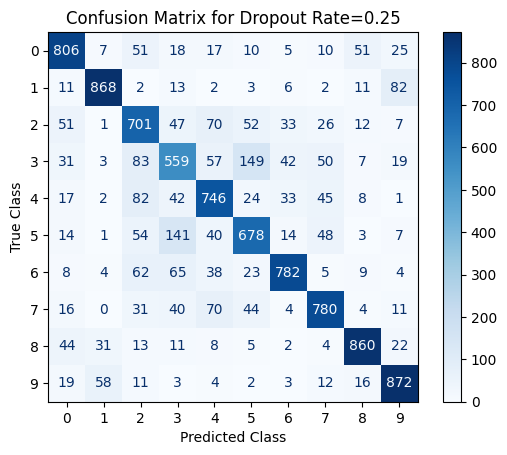

Training model with MaxDropout rate: 0.4 and Config: {'first': False, 'second': False, 'third': True, 'fourth': False, 'fifth': True}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_684 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_685 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_570               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_686 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_571               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_687 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_572               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_294 (MaxDropout)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_688 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_573               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_689 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_574               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_295 (MaxDropout)    │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_114 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_228 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_229 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 28ms/step - accuracy: 0.2943 - loss: 1.8655 - val_accuracy: 0.5865 - val_loss: 1.1482
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.6145 - loss: 1.0812 - val_accuracy: 0.6652 - val_loss: 0.9526
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.6950 - loss: 0.8719 - val_accuracy: 0.6948 - val_loss: 0.8759
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.7476 - loss: 0.7188 - val_accuracy: 0.6815 - val_loss: 0.9744
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.7772 - loss: 0.6331 - val_accuracy: 0.7117 - val_loss: 0.8409
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8140 - loss: 0.5327 - val_accuracy: 0.7437 - val_loss: 0.7767
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8351 - loss: 0.4701 - val_accuracy: 0.7468 - val_loss: 0.7694
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8528 -

<Figure size 1000x1000 with 0 Axes>

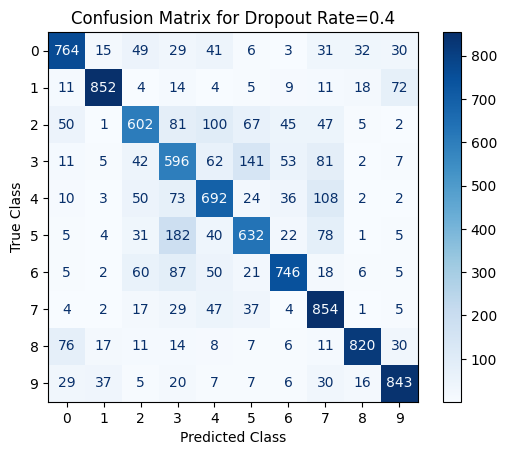

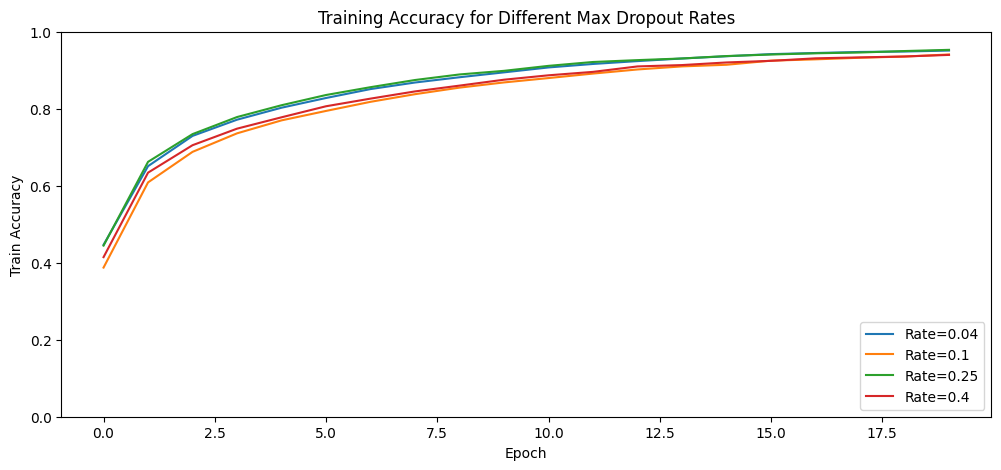

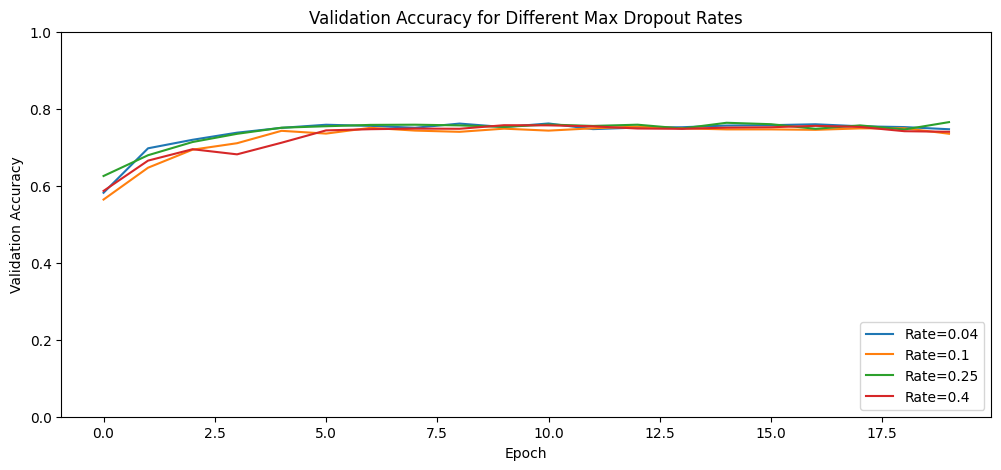

Training model with MaxDropout rate: 0.04 and Config: {'first': False, 'second': True, 'third': False, 'fourth': True, 'fifth': False}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_690 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_691 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_575               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_692 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_576               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_296 (MaxDropout)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_693 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_577               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_694 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_578               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_297 (MaxDropout)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_695 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_579               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_115 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_230 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_231 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 30ms/step - accuracy: 0.3304 - loss: 1.7816 - val_accuracy: 0.5380 - val_loss: 1.2344
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.6211 - loss: 1.0560 - val_accuracy: 0.6929 - val_loss: 0.8702
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.7253 - loss: 0.7814 - val_accuracy: 0.7287 - val_loss: 0.7759
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.7776 - loss: 0.6364 - val_accuracy: 0.7366 - val_loss: 0.7797
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.8155 - loss: 0.5328 - val_accuracy: 0.7513 - val_loss: 0.7365
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8409 - loss: 0.4565 - val_accuracy: 0.7464 - val_loss: 0.8069
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8619 - loss: 0.3945 - val_accuracy: 0.7483 - val_loss: 0.8260
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8830 -

<Figure size 1000x1000 with 0 Axes>

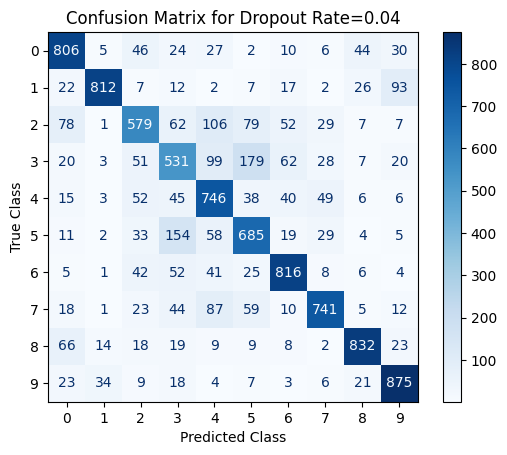

Training model with MaxDropout rate: 0.1 and Config: {'first': False, 'second': True, 'third': False, 'fourth': True, 'fifth': False}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_116"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_696 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_697 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_580               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_698 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_581               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_298 (MaxDropout)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_699 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_582               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_700 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_583               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_299 (MaxDropout)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_701 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_584               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_116 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 27ms/step - accuracy: 0.3306 - loss: 1.7786 - val_accuracy: 0.6008 - val_loss: 1.1203
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.6268 - loss: 1.0389 - val_accuracy: 0.6842 - val_loss: 0.9067
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.7273 - loss: 0.7768 - val_accuracy: 0.7337 - val_loss: 0.7667
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.7765 - loss: 0.6319 - val_accuracy: 0.7457 - val_loss: 0.7529
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 48s 31ms/step - accuracy: 0.8153 - loss: 0.5300 - val_accuracy: 0.7592 - val_loss: 0.7233
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8392 - loss: 0.4514 - val_accuracy: 0.7507 - val_loss: 0.7291
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.8639 - loss: 0.3822 - val_accuracy: 0.7664 - val_loss: 0.7511
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.8846 -

<Figure size 1000x1000 with 0 Axes>

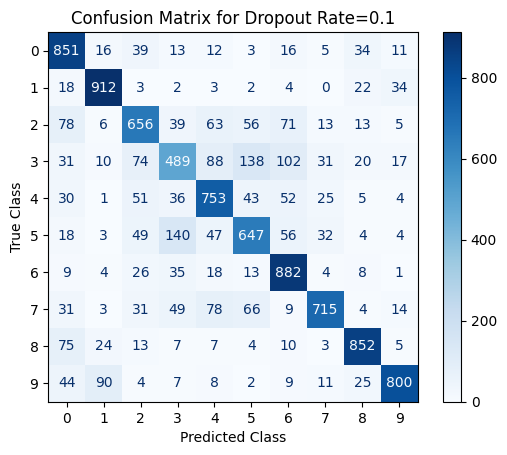

Training model with MaxDropout rate: 0.25 and Config: {'first': False, 'second': True, 'third': False, 'fourth': True, 'fifth': False}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_702 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_703 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_585               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_704 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_586               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_300 (MaxDropout)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_705 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_587               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_706 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_588               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_301 (MaxDropout)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_707 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_589               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_117 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_234 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 28ms/step - accuracy: 0.3233 - loss: 1.7853 - val_accuracy: 0.6046 - val_loss: 1.1033
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.6198 - loss: 1.0566 - val_accuracy: 0.6843 - val_loss: 0.9053
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.7091 - loss: 0.8254 - val_accuracy: 0.7191 - val_loss: 0.8046
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 32ms/step - accuracy: 0.7648 - loss: 0.6808 - val_accuracy: 0.7304 - val_loss: 0.7865
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 48s 31ms/step - accuracy: 0.8002 - loss: 0.5684 - val_accuracy: 0.7357 - val_loss: 0.7735
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.8255 - loss: 0.4932 - val_accuracy: 0.7634 - val_loss: 0.7079
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 54s 34ms/step - accuracy: 0.8543 - loss: 0.4199 - val_accuracy: 0.7519 - val_loss: 0.7821
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.8737 -

<Figure size 1000x1000 with 0 Axes>

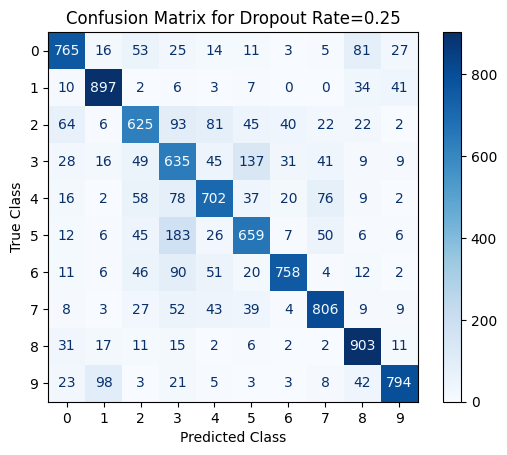

Training model with MaxDropout rate: 0.4 and Config: {'first': False, 'second': True, 'third': False, 'fourth': True, 'fifth': False}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_118"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_708 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_709 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_590               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_710 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_591               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_302 (MaxDropout)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_711 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_592               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_712 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_593               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_303 (MaxDropout)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_713 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_594               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_118 (Flatten)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_236 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_237 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,258 (1.65 MB)

 Trainable params: 433,258 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - accuracy: 0.3011 - loss: 1.8400 - val_accuracy: 0.5924 - val_loss: 1.1265
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.6205 - loss: 1.0605 - val_accuracy: 0.6703 - val_loss: 0.9587
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.7069 - loss: 0.8293 - val_accuracy: 0.7086 - val_loss: 0.8641
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.7568 - loss: 0.6943 - val_accuracy: 0.7325 - val_loss: 0.7769
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.7924 - loss: 0.5896 - val_accuracy: 0.7463 - val_loss: 0.7751
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8189 - loss: 0.5164 - val_accuracy: 0.7435 - val_loss: 0.7969
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.8403 - loss: 0.4533 - val_accuracy: 0.7446 - val_loss: 0.8089
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.8656 -

<Figure size 1000x1000 with 0 Axes>

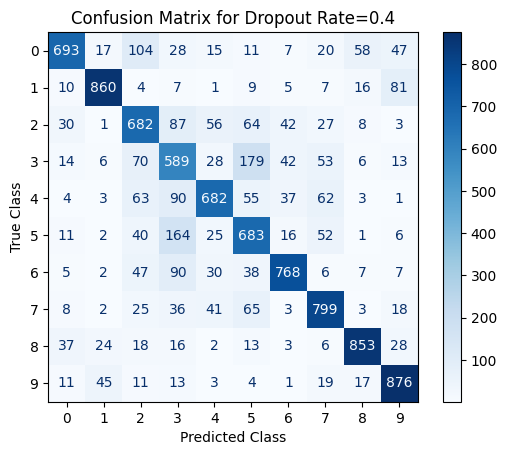

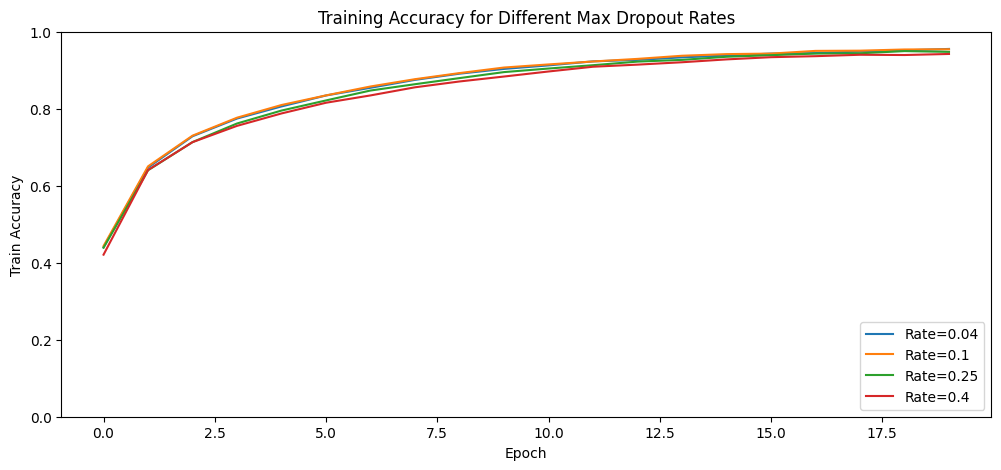

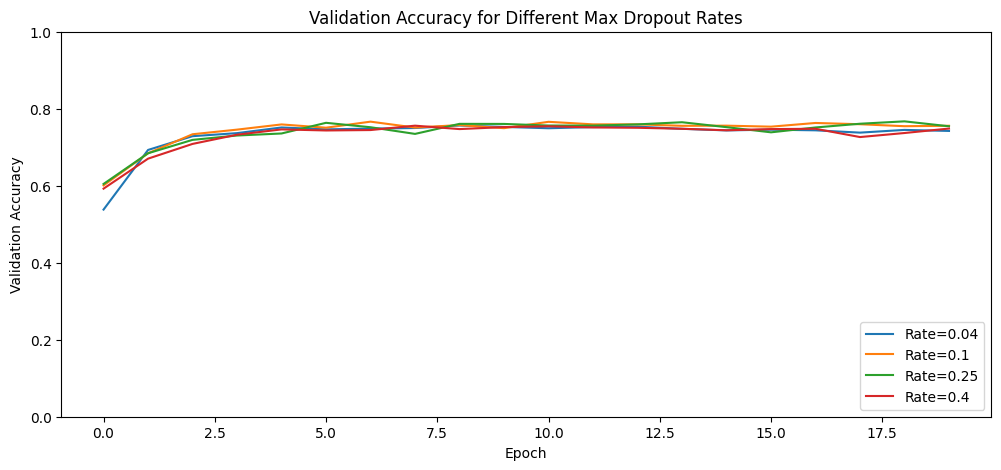

In [135]:
y_train_encoded, y_test_encoded = tf.keras.utils.to_categorical(y_train), tf.keras.utils.to_categorical(y_test)

#dropout_rates = [0.04, 0.07, 0.1, 0.15] # r1, r2, r3, r4
dropout_rates = [0.04, 0.1, 0.25, 0.4] # r1, r3, r5, r6
configurations = [
          {'first': True, 'second': True, 'third': False, 'fourth': False, 'fifth': False}, # config 1
          {'first': False, 'second': False, 'third': False, 'fourth': True, 'fifth': True}, # config 2
          {'first': False, 'second': False, 'third': True, 'fourth': True, 'fifth': False}, # config 3
          {'first': False, 'second': False, 'third': True, 'fourth': False, 'fifth': True}, # config 4
          {'first': False, 'second': True, 'third': False, 'fourth': True, 'fifth': False}, # config 5
        #   {'first': True, 'second': True, 'third': True, 'fourth': True, 'fifth': True}, # config 6
          ]
all_histories = []
for config in configurations:
    histories = []
    for rate in dropout_rates:
        print(f"Training model with MaxDropout rate: {rate} and Config: {config}")
        model = create_model(rate, config)

        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

        history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])
        histories.append(history)

        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
        print('\nTest accuracy for rate {}: {}'.format(rate, test_acc))
        # Prediction
        y_pred = model.predict(x_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test_encoded, axis=1)

        # Compute the confusion matrix
        cm = confusion_matrix(y_true_classes, y_pred_classes)

        # Display the confusion matrix
        plt.figure(figsize=(10, 10))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for Dropout Rate={rate}')
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.show()

    #Plot the accuracies
    plt.figure(figsize=(12, 5))
    for i, history in enumerate(histories):
        plt.plot(history.history['accuracy'], label=f'Rate={dropout_rates[i]}')

    plt.title('Training Accuracy for Different Max Dropout Rates')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

    plt.figure(figsize=(12, 5))
    for i, history in enumerate(histories):
        plt.plot(history.history['val_accuracy'], label=f'Rate={dropout_rates[i]}')

    plt.title('Validation Accuracy for Different Max Dropout Rates')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

    all_histories.append(histories)
    





Max validation accuracy for rate 0.04: 0.756600022315979
Max validation accuracy for rate 0.1: 0.7616999745368958
Max validation accuracy for rate 0.25: 0.7513999938964844
Max validation accuracy for rate 0.4: 0.7677000164985657


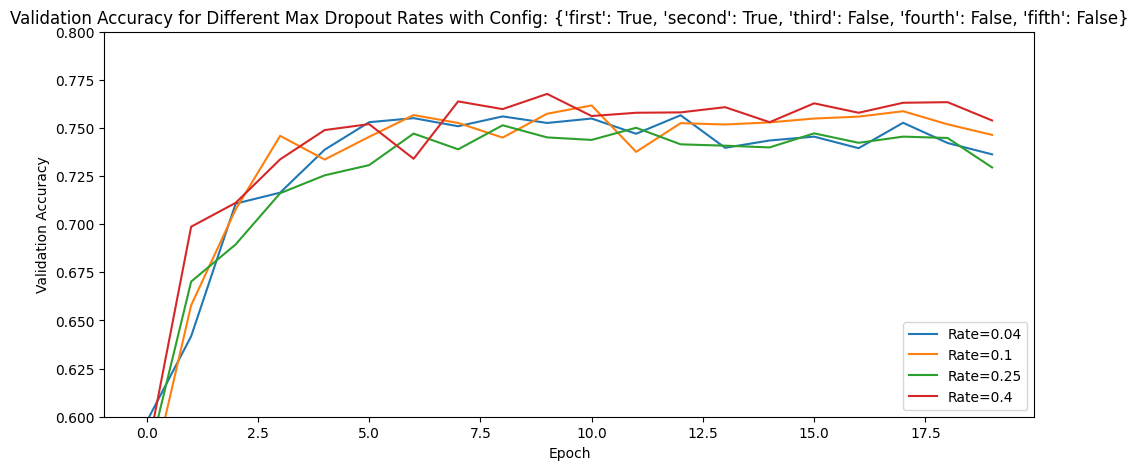

Min validation loss for rate 0.04: 0.7671800255775452
Min validation loss for rate 0.1: 0.7592321634292603
Min validation loss for rate 0.25: 0.7622877359390259
Min validation loss for rate 0.4: 0.7418547868728638


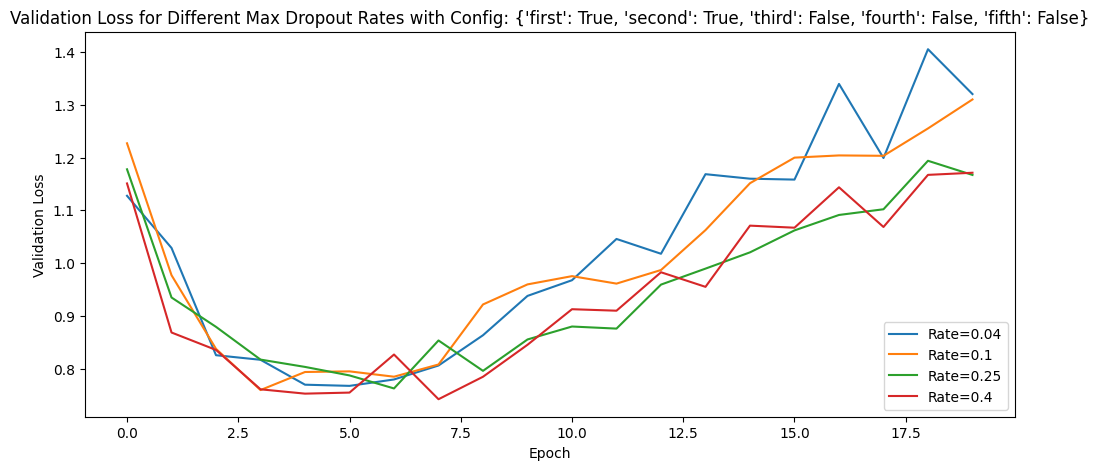

Max validation accuracy for rate 0.04: 0.760699987411499
Max validation accuracy for rate 0.1: 0.7670000195503235
Max validation accuracy for rate 0.25: 0.7591000199317932
Max validation accuracy for rate 0.4: 0.7681999802589417


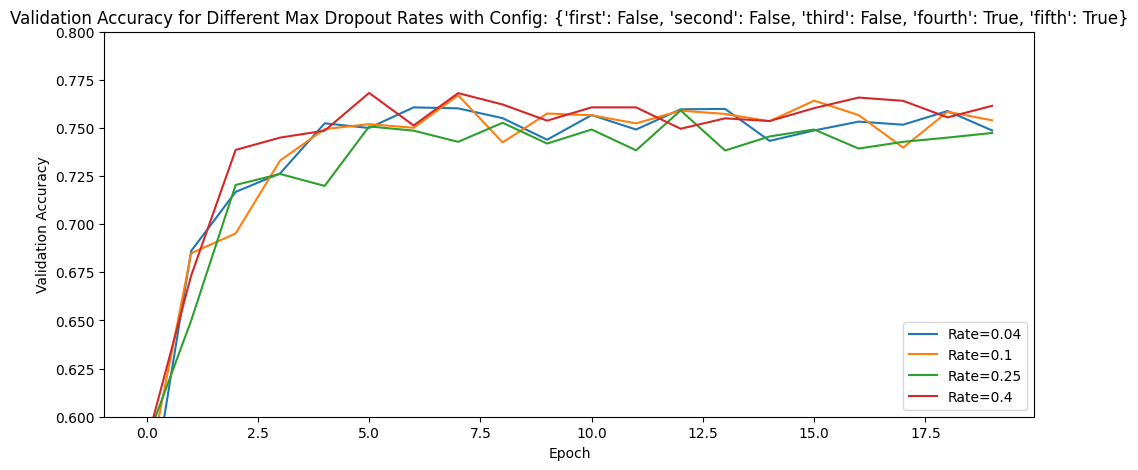

Min validation loss for rate 0.04: 0.742393434047699
Min validation loss for rate 0.1: 0.740160346031189
Min validation loss for rate 0.25: 0.7497000098228455
Min validation loss for rate 0.4: 0.7352979183197021


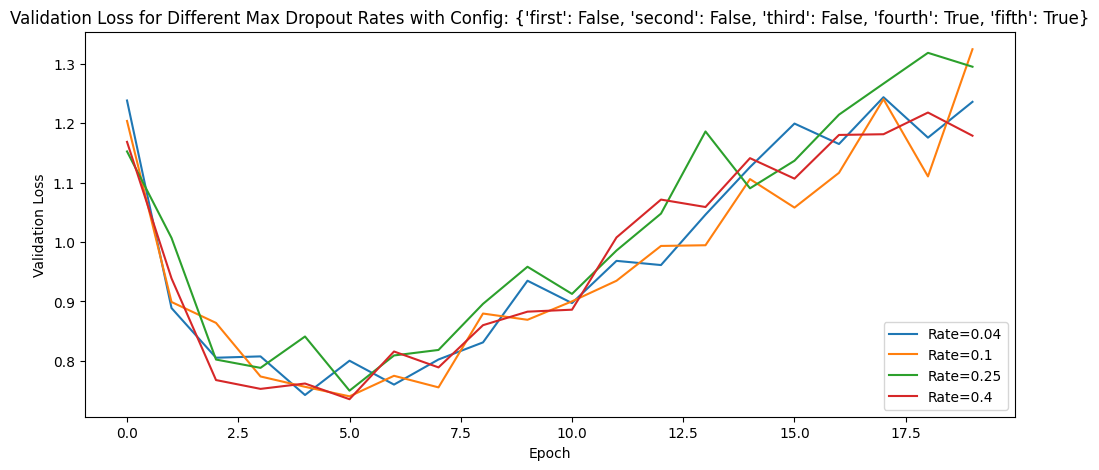

Max validation accuracy for rate 0.04: 0.7638999819755554
Max validation accuracy for rate 0.1: 0.7699000239372253
Max validation accuracy for rate 0.25: 0.762499988079071
Max validation accuracy for rate 0.4: 0.7663999795913696


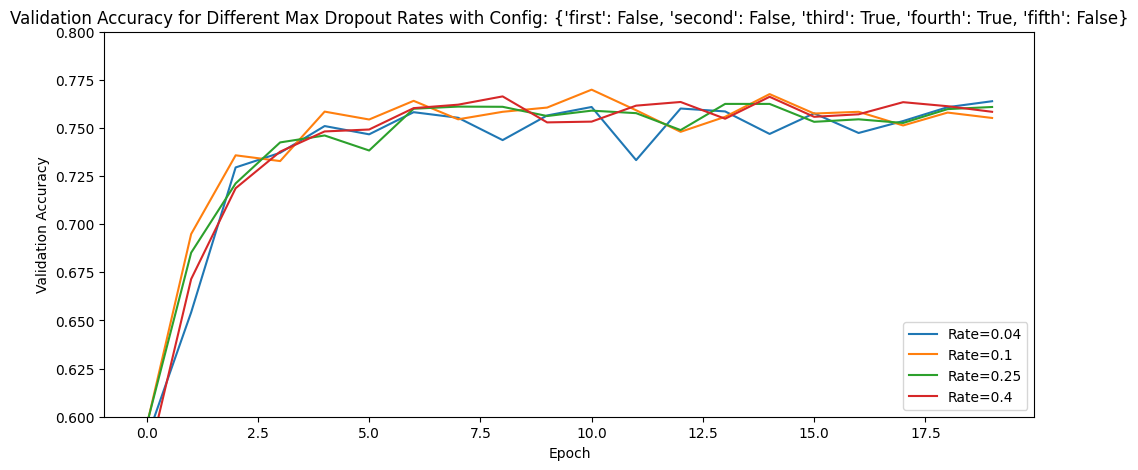

Min validation loss for rate 0.04: 0.7343270182609558
Min validation loss for rate 0.1: 0.7441747784614563
Min validation loss for rate 0.25: 0.7586776614189148
Min validation loss for rate 0.4: 0.7541121244430542


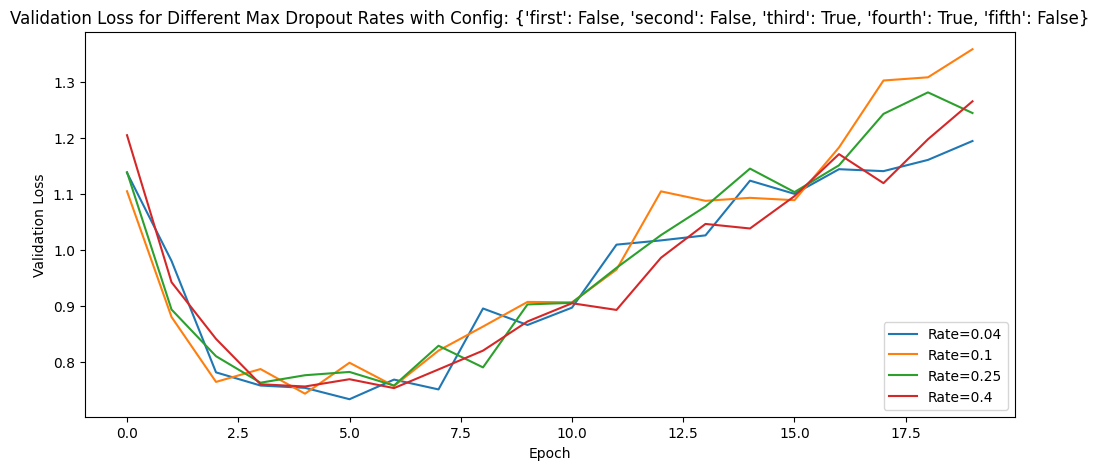

Max validation accuracy for rate 0.04: 0.7616999745368958
Max validation accuracy for rate 0.1: 0.753600001335144
Max validation accuracy for rate 0.25: 0.7652000188827515
Max validation accuracy for rate 0.4: 0.7572000026702881


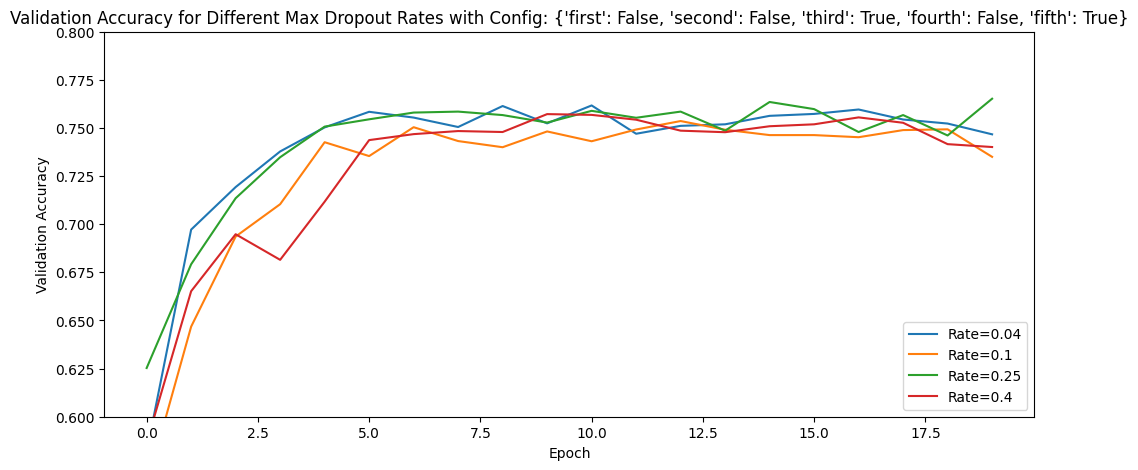

Min validation loss for rate 0.04: 0.748434841632843
Min validation loss for rate 0.1: 0.7561162710189819
Min validation loss for rate 0.25: 0.747286856174469
Min validation loss for rate 0.4: 0.7693988084793091


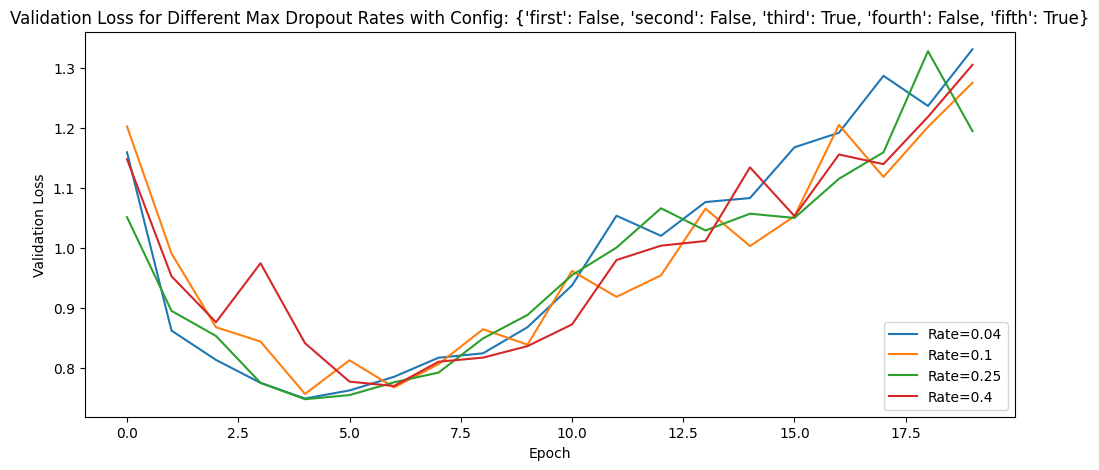

Max validation accuracy for rate 0.04: 0.7563999891281128
Max validation accuracy for rate 0.1: 0.7663999795913696
Max validation accuracy for rate 0.25: 0.7671999931335449
Max validation accuracy for rate 0.4: 0.7559999823570251


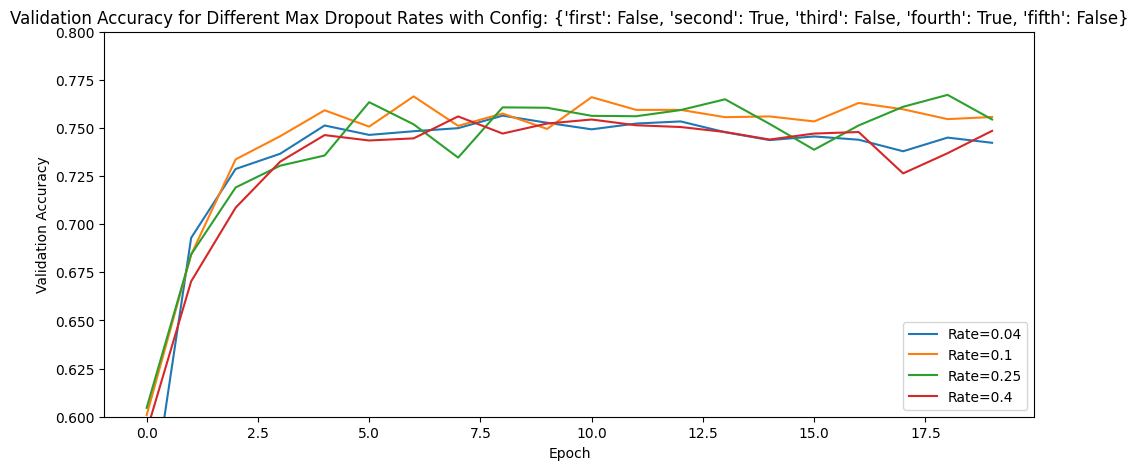

Min validation loss for rate 0.04: 0.7365378141403198
Min validation loss for rate 0.1: 0.7233489155769348
Min validation loss for rate 0.25: 0.7078842520713806
Min validation loss for rate 0.4: 0.7751293778419495


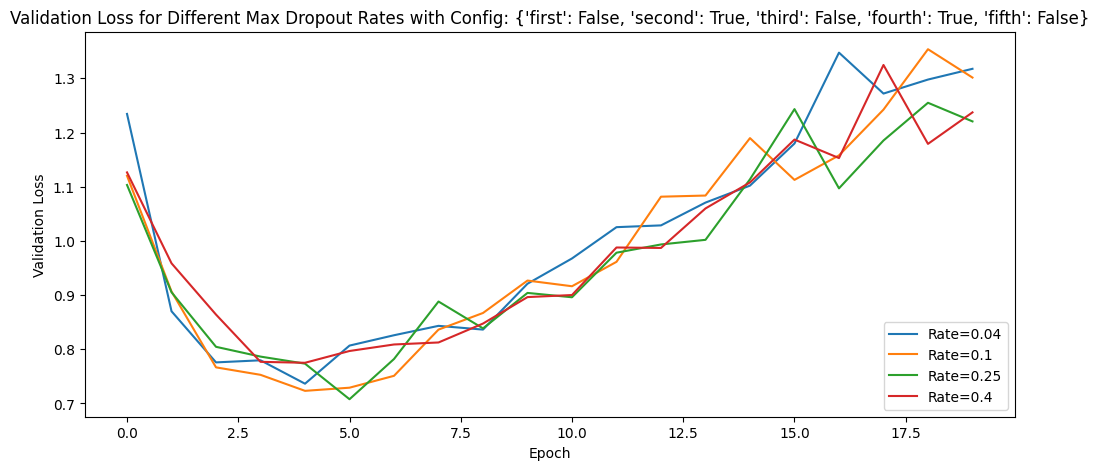

In [136]:
for config in configurations:
    histories = all_histories[configurations.index(config)]
    plt.figure(figsize=(12, 5))
    for i, history in enumerate(histories):
        plt.plot(history.history['val_accuracy'], label=f'Rate={dropout_rates[i]}')
        # find max validation accuracy and print
        max_val_acc = max(history.history['val_accuracy'])
        print(f'Max validation accuracy for rate {dropout_rates[i]}: {max_val_acc}')
        # find generalization gap of the model at the point of max validation accuracy
        # max_val_acc_idx = history.history['val_accuracy'].index(max_val_acc)
        # generalization_gap = max_val_acc - history.history['accuracy'][max_val_acc_idx]
        # print(f'Generalization gap for rate {dropout_rates[i]}: {generalization_gap}')

    plt.title('Validation Accuracy for Different Max Dropout Rates with Config: {}'.format(config))
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.ylim([.6, .8])
    plt.legend(loc='lower right')
    plt.show()    

    plt.figure(figsize=(12, 5))
    for i, history in enumerate(histories):
        plt.plot(history.history['val_loss'], label=f'Rate={dropout_rates[i]}')
        min_val_loss = min(history.history['val_loss'])
        print(f'Min validation loss for rate {dropout_rates[i]}: {min_val_loss}')

    plt.title('Validation Loss for Different Max Dropout Rates with Config: {}'.format(config))
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    # plt.ylim([.6, .8])
    plt.legend(loc='lower right')
    plt.show()    





In [109]:
for config in configurations:
    histories = all_histories[configurations.index(config)]
    plt.figure(figsize=(12, 5))
    for i, history in enumerate(histories):
        plt.plot(history.history['val_accuracy'], label=f'Rate={dropout_rates[i]}')

    plt.title('Validation Accuracy for Different Max Dropout Rates with Config: {}'.format(config))
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.ylim([.6, .8])
    plt.legend(loc='lower right')
    plt.show()    

IndexError: list index out of range

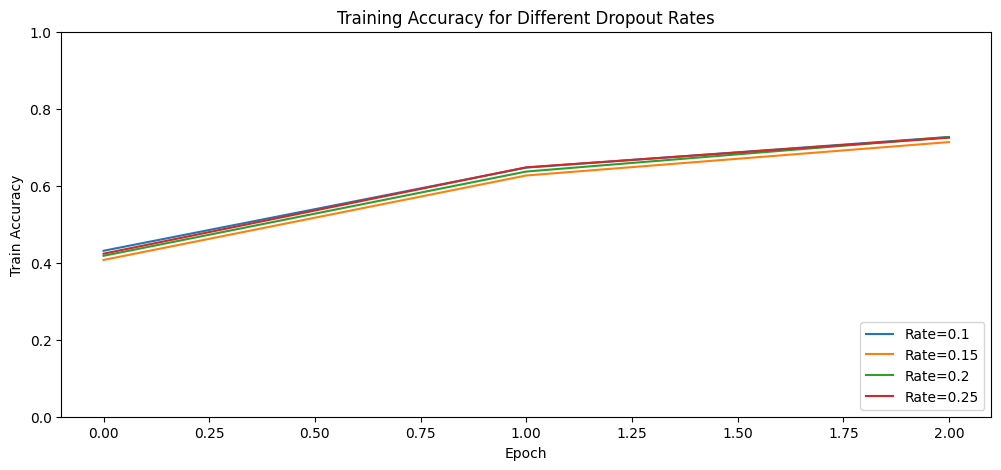

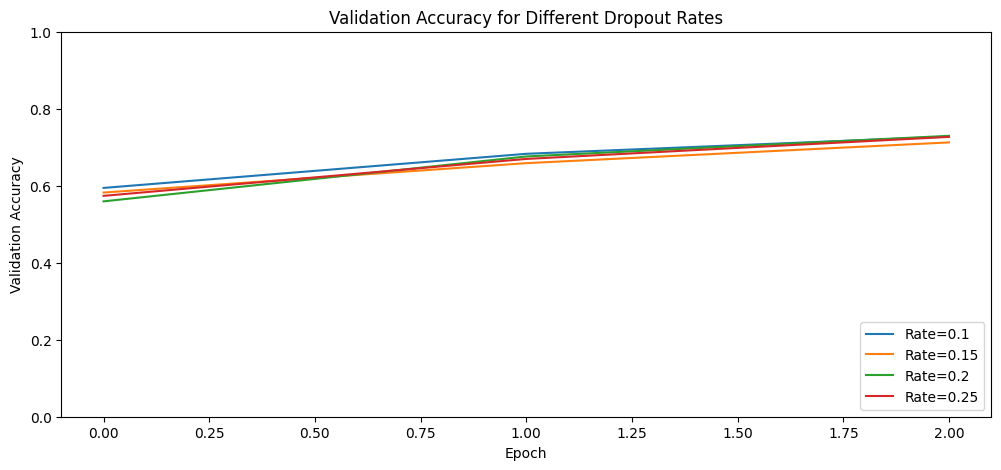

In [67]:
#Plot the accuracies
plt.figure(figsize=(12, 5))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'Rate={dropout_rates[i]}')

plt.title('Training Accuracy for Different Max Dropout Rates')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(12, 5))
for i, history in enumerate(histories):
    plt.plot(history.history['val_accuracy'], label=f'Rate={dropout_rates[i]}')

plt.title('Validation Accuracy for Different Max Dropout Rates')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


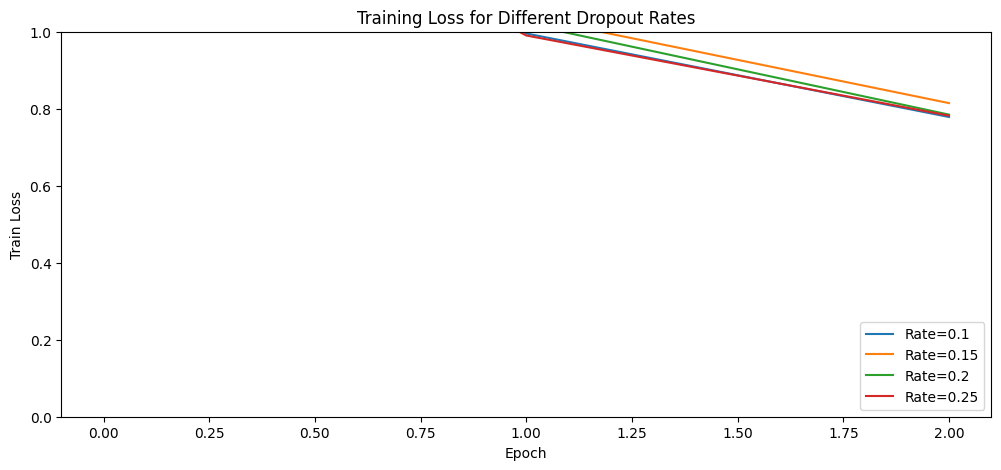

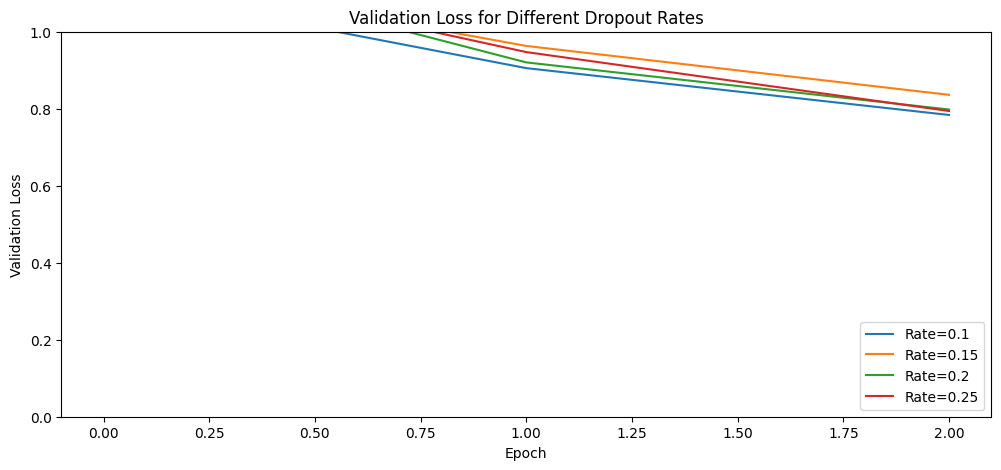

In [68]:
#plot loss
plt.figure(figsize=(12, 5))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Rate={dropout_rates[i]}')

plt.title('Training Loss for Different Max Dropout Rates')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(12, 5))
for i, history in enumerate(histories):
    plt.plot(history.history['val_loss'], label=f'Rate={dropout_rates[i]}')

plt.title('Validation Loss for Different Max Dropout Rates')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()



## Save the trained Model

In [52]:
#save the trained model (Parameters) so I can use it again without training again
model.save('cifar10_cnn.h5')
#save the trained model (Weights) so I can use it again without training again
model.save('cifar10_cnn_weights.h5')


## Load the trained Model

In [ ]:
#load the trained model (Parameters) so I can use it again without training again
#model = keras.models.load_model('cifar10_cnn.h5')

#load the trained model (Weights) so I can use it again without training again

#model.load_weights('cifar10_cnn_weights.h5')